# Retail Store Time-Series Analysis

### Importing standard Python libraries

In [31]:
import numpy as np
import scipy as sp 
import pandas as pd 

import warnings
import datetime 

import matplotlib.pyplot as plt 
import matplotlib.dates as mdates
from matplotlib.pyplot import cm

%matplotlib inline
import seaborn as sns

And then reading in the datasets

In [32]:
warnings.filterwarnings('ignore')

features = pd.read_csv('./Features_dataset.csv')
stores = pd.read_csv('./stores_dataset.csv')
sales = pd.read_csv('./sales_dataset.csv')

# Data Exploration 

In this section I will preliminarily go over some basic data exploration.  The first and objectively most important is to figure out the data that we do have, and to this end, I first list out all the column names and find out which columns have NaN data, so we have a heads up on if we need to do some further cleaning. Currently, we are given at least 3 different .csv files, which likely means that at somepoint later down the pipeline we might need to impute data.  

In [33]:
print(f"Features in the Feature columns: {features.columns}")
print(f"Features in the Stores columns: {stores.columns}")
print(f"Features in the Sales columns: {sales.columns}")

print(f"Number of Entires in Features: {len(features.values)}")
print(f"Number of Entires in Stores: {len(stores.values)}")
print(f"Number of Entires in Sales: {len(sales.values)}")

print("Features: ")
nan_counts_Features = features.isna().sum()
print(nan_counts_Features)
print(features.dtypes)
print("\n \n \n")

print("Stores: ")
print(stores.dtypes)
nan_counts_stores = stores.isna().sum()
print(nan_counts_stores)
print("\n \n \n")

print("Sales: ")
print(sales.dtypes)
nan_counts_sales = sales.isna().sum()
print(nan_counts_sales)
print("\n \n \n")


# print(np.unique(sales['Store']))
# print(sales_with_stores[['Store', 'Type']][::25000])

Features in the Feature columns: Index(['Store', 'Date', 'Temperature', 'Fuel_Price', 'MarkDown1', 'MarkDown2',
       'MarkDown3', 'MarkDown4', 'MarkDown5', 'CPI', 'Unemployment',
       'IsHoliday'],
      dtype='object')
Features in the Stores columns: Index(['Store', 'Type', 'Size'], dtype='object')
Features in the Sales columns: Index(['Store', 'Dept', 'Date', 'Weekly_Sales', 'IsHoliday'], dtype='object')
Number of Entires in Features: 8190
Number of Entires in Stores: 45
Number of Entires in Sales: 421570
Features: 
Store              0
Date               0
Temperature        0
Fuel_Price         0
MarkDown1       4158
MarkDown2       5269
MarkDown3       4577
MarkDown4       4726
MarkDown5       4140
CPI              585
Unemployment     585
IsHoliday          0
dtype: int64
Store             int64
Date             object
Temperature     float64
Fuel_Price      float64
MarkDown1       float64
MarkDown2       float64
MarkDown3       float64
MarkDown4       float64
MarkDown5      

### So after looking at what the data contains: 

### Stores 
The stores.csv files holds information about the type of stores (A, B, and C) and the size of the stores we are dealing with.  There is not much else to this file.  

### Sales 
The sales.csv file contains the *weekly* sales over a period of about 3 years for each individual department in each store, which means that this dataframe is effectively one of a timeseries.  This is an important aspect of the dataset because it implores us to examine not only each store, but the variation of sales in each department.  It also gives information when the holidays occur.  I have decided in this section to join the Stores and Sales dataframes because it is a very simply join where I simply add the *Type* of the store to the Sales dataframe.  

### Features
The features dataframe is another time series dataframe which gives us information about the temperature, fuelprice, markdowns, holidays, consumer price index (CPI), and unemployment over weekly for the 3 year span that we had data for.  After doing some preliminary data exploration we can see that the only data which has NaNs are the Markdowns, CPI, and unemployment numbers.

## Merging Datasets

In this next cell I will merger the sales and store data using an inner product (which will effectively match each store ID to it's corresponding store type). The purpose of merging the datasets is to examine which stores and departments typically yield the largest amount of profits.  It will be done for later analysis.

In [77]:
# I took a look at the dates and it appears that they are in Day-Month-Year, so let's make that explicit
# features['Date'] = pd.to_datetime(features['Date'],dayfirst=True)
# sales['Date'] = pd.to_datetime(features['Date'],dayfirst=True)
sales_with_stores = pd.merge(sales, stores,  on='Store', how='inner')
sales_with_stores.set_index('Date')
print(sales_with_stores.head)
print(sales_with_stores.dtypes)
print(sales_with_stores)
sales_with_stores['Weekly_Sales_by_Size'] = sales_with_stores['Weekly_Sales']/sales_with_stores['Size']

<bound method NDFrame.head of         Store  Dept       Date  Weekly_Sales  IsHoliday Type    Size
0           1     1 2010-02-05      24924.50      False    A  151315
1           1     1 2010-02-12      46039.49       True    A  151315
2           1     1 2010-02-19      41595.55      False    A  151315
3           1     1 2010-02-26      19403.54      False    A  151315
4           1     1 2010-03-05      21827.90      False    A  151315
...       ...   ...        ...           ...        ...  ...     ...
421565     45    98 2012-09-28        508.37      False    B  118221
421566     45    98 2012-10-05        628.10      False    B  118221
421567     45    98 2012-10-12       1061.02      False    B  118221
421568     45    98 2012-10-19        760.01      False    B  118221
421569     45    98 2012-10-26       1076.80      False    B  118221

[421570 rows x 7 columns]>
Store                    int64
Dept                     int64
Date            datetime64[ns]
Weekly_Sales         

# Exploratory Data Analysis

## Store and Sales Data

<Axes: xlabel='Type', ylabel='count'>

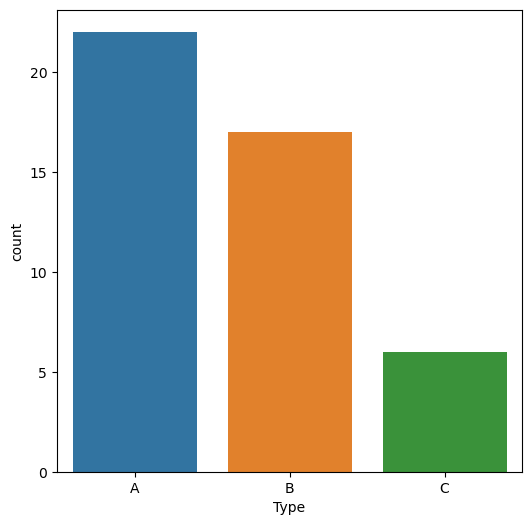

In [35]:
fig, ax = plt.subplots(figsize=(6,6))
sns.countplot(data=stores, x='Type', hue='Type', orient='h')

<Axes: ylabel='Size'>

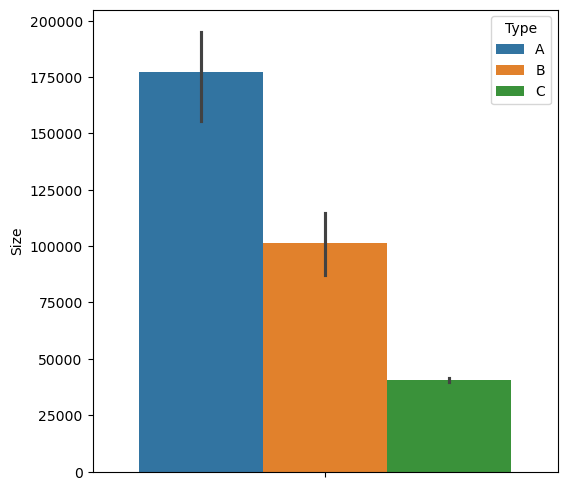

In [36]:
fig, ax = plt.subplots(figsize=(6,6))
sns.barplot(data=stores, y='Size', hue='Type', orient='v')

In the above plots, we simply plot the number of Stores of a given type, and then the sizes of these different stores.  The clear distinction between stores A, B, and C are the sizes, with A being the biggest, then B, and C being the smallest.  

## Dates 

As is common with time-series data, we should first ensure that each department in each store have the same number of dates.  The assumption that we can make for simplicity currently is that if a date is missing from the data, that the total weekly sales for that missing data should be 0.  The logical reasoning for this being that nothing was sold that day, or the department did not exist to make sales. 

In [37]:
# Let's extract the date data in this cell 
features['Date'] = pd.to_datetime(features['Date'], format="%d/%m/%Y")
sales['Date'] = pd.to_datetime(sales['Date'], format="%d/%m/%Y")
sales_with_stores['Date'] = pd.to_datetime(sales_with_stores['Date'], format="%d/%m/%Y")
print(features['Date'])

holidayDates = features.loc[features['IsHoliday'] == True, 'Date']
print(holidayDates)

0      2010-02-05
1      2010-02-12
2      2010-02-19
3      2010-02-26
4      2010-03-05
          ...    
8185   2013-06-28
8186   2013-07-05
8187   2013-07-12
8188   2013-07-19
8189   2013-07-26
Name: Date, Length: 8190, dtype: datetime64[ns]
1      2010-02-12
31     2010-09-10
42     2010-11-26
47     2010-12-31
53     2011-02-11
          ...    
8113   2012-02-10
8143   2012-09-07
8154   2012-11-23
8159   2012-12-28
8165   2013-02-08
Name: Date, Length: 585, dtype: datetime64[ns]


In [38]:
# print(sales.columns, sales_with_stores.columns)
print(f"Number of elements in Sales: {len(sales)} \t Number of elements after join: {len(sales_with_stores)}")
print(sales_with_stores.columns)

# Get the number of Departments in each store
# print((sales_with_stores['Type'] == 'A').values)
A_stores = sales_with_stores.iloc[(sales_with_stores['Type'] == 'A').values]
unique_Astores = np.unique(A_stores['Store'])
print(f"Number of Type A Stores: {unique_Astores}")

B_stores = sales_with_stores.iloc[(sales_with_stores['Type'] == 'B').values]
unique_Bstores = np.unique(B_stores['Store'])
print(f"Number of Type B Stores: {unique_Bstores}")

C_stores = sales_with_stores.iloc[(sales_with_stores['Type'] == 'C').values]
unique_Cstores = np.unique(C_stores['Store'])
print(f"Number of Type C Stores: {unique_Cstores}")




Number of elements in Sales: 421570 	 Number of elements after join: 421570
Index(['Store', 'Dept', 'Date', 'Weekly_Sales', 'IsHoliday', 'Type', 'Size',
       'Weekly_Sales_by_Size'],
      dtype='object')
Number of Type A Stores: [ 1  2  4  6  8 11 13 14 19 20 24 26 27 28 31 32 33 34 36 39 40 41]
Number of Type B Stores: [ 3  5  7  9 10 12 15 16 17 18 21 22 23 25 29 35 45]
Number of Type C Stores: [30 37 38 42 43 44]


In [39]:
_ = sales_with_stores.pivot_table(index=['Date', 'Store', 'Dept', 'Type'], \
    values=['IsHoliday', 'Size', 'Weekly_Sales', 'Weekly_Sales_by_Size'], fill_value=0.).reset_index()

print(_.head)
print(type(_))

<bound method NDFrame.head of              Date  Store  Dept Type  IsHoliday      Size  Weekly_Sales  \
0      2010-02-05      1     1    A        0.0  151315.0      24924.50   
1      2010-02-05      1     2    A        0.0  151315.0      50605.27   
2      2010-02-05      1     3    A        0.0  151315.0      13740.12   
3      2010-02-05      1     4    A        0.0  151315.0      39954.04   
4      2010-02-05      1     5    A        0.0  151315.0      32229.38   
...           ...    ...   ...  ...        ...       ...           ...   
421565 2012-10-26     45    93    B        0.0  118221.0       2487.80   
421566 2012-10-26     45    94    B        0.0  118221.0       5203.31   
421567 2012-10-26     45    95    B        0.0  118221.0      56017.47   
421568 2012-10-26     45    97    B        0.0  118221.0       6817.48   
421569 2012-10-26     45    98    B        0.0  118221.0       1076.80   

        Weekly_Sales_by_Size  
0                   0.164719  
1                  

In [40]:
for A_storeID in unique_Astores:
    
    store = A_stores.iloc[(A_stores['Store'] == A_storeID).values]
    depts = np.unique(store['Dept'].values)
    # print(f"Number of Departments: {len(np.unique(store['Dept'].values))}")
    for DeptID in depts:
        store_dept = store.iloc[(store['Dept'] == DeptID).values]
        if len(store_dept) < 143: print(f"StoreID {A_storeID} \t  DepartmentID {DeptID} --> Number of Dates: {len(store_dept)}")

for B_storeID in unique_Bstores:
    
    store = B_stores.iloc[(B_stores['Store'] == B_storeID).values]
    depts = np.unique(store['Dept'].values)
    # print(f"Number of Departments: {len(np.unique(store['Dept'].values))}")
    for DeptID in depts:
        store_dept = store.iloc[(store['Dept'] == DeptID).values]
        if len(store_dept) < 143: print(f"StoreID {B_storeID} \t  DepartmentID {DeptID} --> Number of Dates: {len(store_dept)}")


for A_storeID in unique_Astores:
    
    store = A_stores.iloc[(A_stores['Store'] == A_storeID).values]
    depts = np.unique(store['Dept'].values)
    # print(f"Number of Departments: {len(np.unique(store['Dept'].values))}")
    for DeptID in depts:
        store_dept = store.iloc[(store['Dept'] == DeptID).values]
        if len(store_dept) < 143: print(f"StoreID {A_storeID} \t  DepartmentID {DeptID} --> Number of Dates: {len(store_dept)}")

StoreID 1 	  DepartmentID 18 --> Number of Dates: 113
StoreID 1 	  DepartmentID 45 --> Number of Dates: 71
StoreID 1 	  DepartmentID 47 --> Number of Dates: 22
StoreID 1 	  DepartmentID 48 --> Number of Dates: 125
StoreID 1 	  DepartmentID 51 --> Number of Dates: 33
StoreID 1 	  DepartmentID 54 --> Number of Dates: 133
StoreID 1 	  DepartmentID 77 --> Number of Dates: 3
StoreID 1 	  DepartmentID 78 --> Number of Dates: 4
StoreID 1 	  DepartmentID 96 --> Number of Dates: 122
StoreID 1 	  DepartmentID 99 --> Number of Dates: 37
StoreID 2 	  DepartmentID 18 --> Number of Dates: 113
StoreID 2 	  DepartmentID 39 --> Number of Dates: 4
StoreID 2 	  DepartmentID 45 --> Number of Dates: 66
StoreID 2 	  DepartmentID 47 --> Number of Dates: 22
StoreID 2 	  DepartmentID 48 --> Number of Dates: 139
StoreID 2 	  DepartmentID 51 --> Number of Dates: 12
StoreID 2 	  DepartmentID 54 --> Number of Dates: 136
StoreID 2 	  DepartmentID 60 --> Number of Dates: 111
StoreID 2 	  DepartmentID 77 --> Number o

## Store Type

Number of elements in Sales: 421570 	 Number of elements after join: 421570
Number of Type A Stores: 22
Number of Type B Stores: 17
Number of Type C Stores: 6


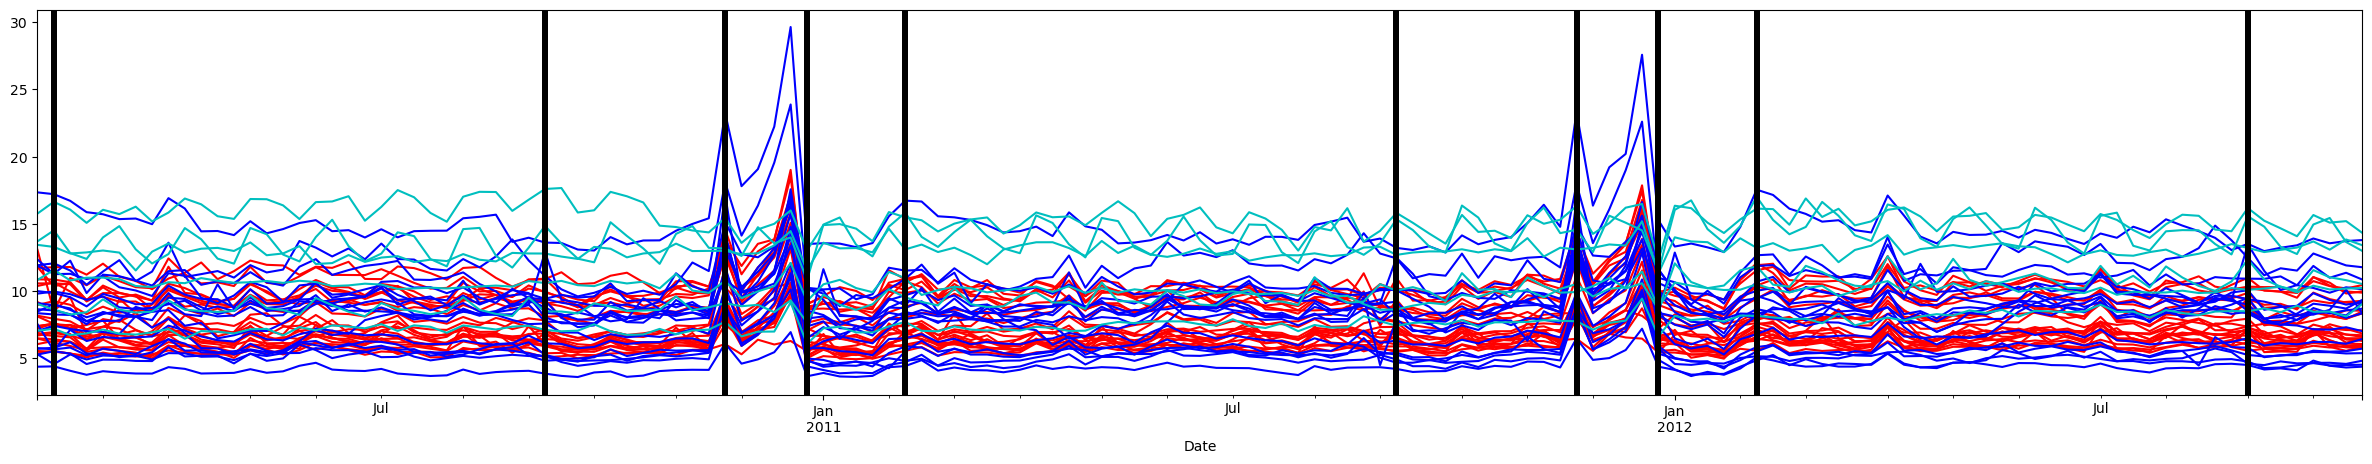

In [49]:

# print(sales.columns, sales_with_stores.columns)
print(f"Number of elements in Sales: {len(sales)} \t Number of elements after join: {len(sales_with_stores)}")
fig, ax = plt.subplots(figsize=(30,5))

# Get the number of Departments in each store
# print((sales_with_stores['Type'] == 'A').values)
A_stores = sales_with_stores.iloc[(sales_with_stores['Type'] == 'A').values]
unique_Astores = np.unique(A_stores['Store'])
print(f"Number of Type A Stores: {len(unique_Astores)}")

B_stores = sales_with_stores.iloc[(sales_with_stores['Type'] == 'B').values]
unique_Bstores = np.unique(B_stores['Store'])
print(f"Number of Type B Stores: {len(unique_Bstores)}")

C_stores = sales_with_stores.iloc[(sales_with_stores['Type'] == 'C').values]
unique_Cstores = np.unique(C_stores['Store'])
print(f"Number of Type C Stores: {len(unique_Cstores)}")

# We need to be careful here because a lot of the data here seems to not have data for ALL dates 
for A_storeID in unique_Astores:
    # print(len(A_stores.iloc[(A_stores['Store'] == A_storeID).values]['Weekly_Sales']))
    # print(A_stores.iloc[(A_stores['Store'] == A_storeID).values].groupby('Date')['Weekly_Sales'].sum())
    A_stores.iloc[(A_stores['Store'] == A_storeID).values].groupby('Date')['Weekly_Sales_by_Size'].sum().plot(x='Date', y='Weekly_Sales', \
                                                                                  kind='line', color='r', \
                                                                                  label=A_storeID, ax=ax)
    

for B_storeID in unique_Bstores:
    # print(len(B_stores.iloc[(B_stores['Store'] == B_storeID).values]['Weekly_Sales']))
    B_stores.iloc[(B_stores['Store'] == B_storeID).values].groupby('Date')['Weekly_Sales_by_Size'].sum().plot(x='Date', y='Weekly_Sales', \
                                                                                  kind='line', color='b', \
                                                                                  label=B_storeID, ax=ax)


for C_storeID in unique_Cstores:
    # print(len(C_stores.iloc[(C_stores['Store'] == C_storeID).values]['Weekly_Sales']))
    C_stores.iloc[(C_stores['Store'] == C_storeID).values].groupby('Date')['Weekly_Sales_by_Size'].sum().plot(x='Date', y='Weekly_Sales', \
                                                                                  kind='line', color='c', \
                                                                                  label=C_storeID, ax=ax)

for holiday in holidayDates:
    ax.axvline(holiday, c='k', lw=3.)

From the plot above, where I examine the sales of of each type of store, we can clearly see that stores of Type A and B see a marked increase in the number of sales around the holiday season, whereas stores of Type C typically do see stable sales throughout the year.  What is noticeable however, is that the increase is noted across in Type A and B stores, is that ALL departments seemingly show an increase in the number of sales around holiday season (especially during the later months), however Type C stores do not.  It could benefit Type C stores to start departments which could increase sales around the holiday season.  

From doing some data exploration of the individual store types, it appears that the variations in the peaks between stores is not vastly different from each other.  However, stores classified in Category A seem to have made more sales than those in Categories B and C.  This is not surprising given our previous data exploration which showed that Category A stores were the largest in size, while those in Category C were the smallest.  We can also observe from the observed plot that the fluctuations in the sales is primarily quite uniform across all categories of stores.  This indicates that something else is driving the these fluctuations.  

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


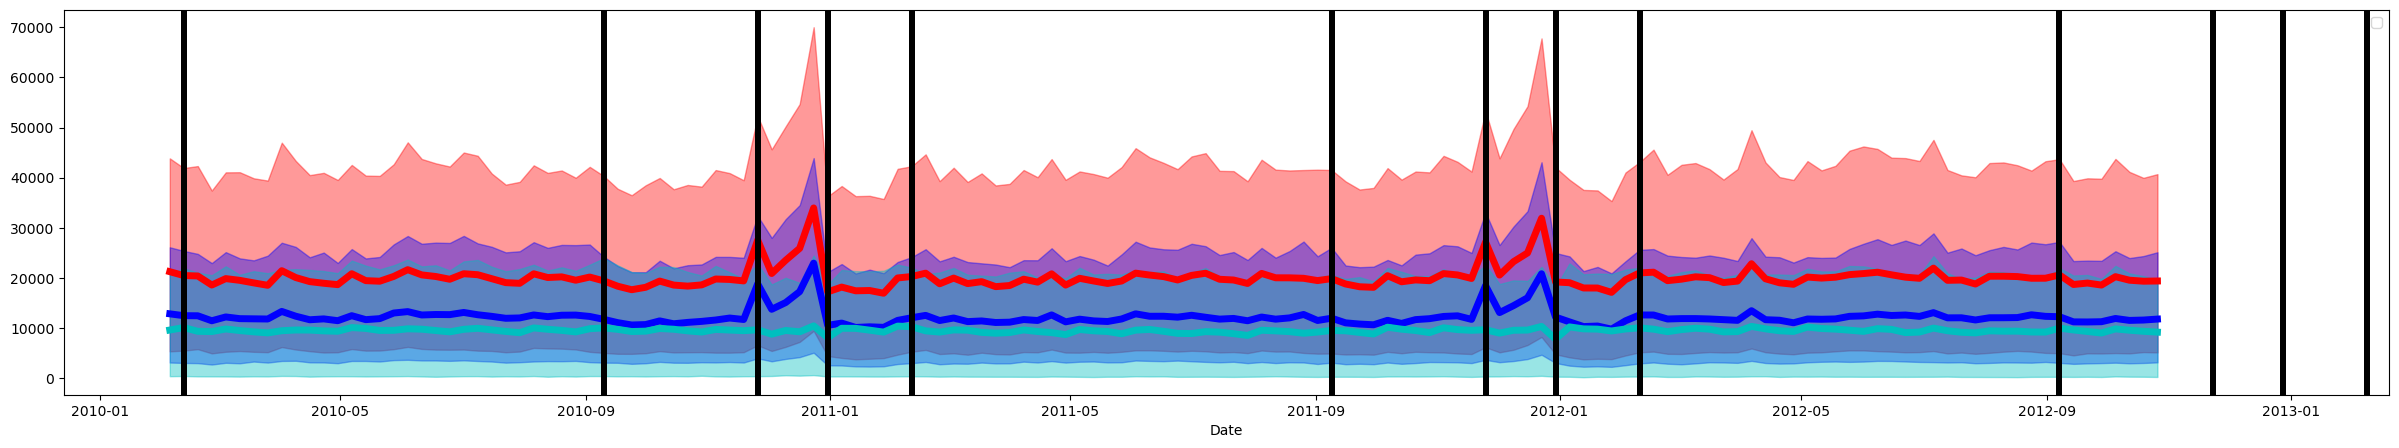

In [44]:
fig, ax = plt.subplots(figsize=(30, 5))

def percentile(n):
    def percentile_(x):
        return x.quantile(n)
    percentile_.__name__ = 'percentile_{:02.0f}'.format(n*100)
    return percentile_
    
dates = np.unique(A_stores['Date'])
A_aggStats = A_stores.groupby('Date')['Weekly_Sales'].agg(['mean', 'std', percentile(0.34), percentile(0.86)])
ax.plot(dates, A_aggStats['mean'], c='r', lw=5)
ax.fill_between(dates, y1=A_aggStats['percentile_34'], y2=A_aggStats['percentile_86'], color='r', alpha=0.4)

dates = np.unique(B_stores['Date'])
B_aggStats = B_stores.groupby('Date')['Weekly_Sales'].agg(['mean', 'std', percentile(0.34), percentile(0.86)])
ax.plot(dates, B_aggStats['mean'], c='b', lw=5)
ax.fill_between(dates, y1=B_aggStats['percentile_34'], y2=B_aggStats['percentile_86'], color='b', alpha=0.4)

dates = np.unique(C_stores['Date'])
C_aggStats = C_stores.groupby('Date')['Weekly_Sales'].agg(['mean', 'std', percentile(0.34), percentile(0.86)])
ax.plot(dates, C_aggStats['mean'], c='c', lw=5)
ax.fill_between(dates, y1=C_aggStats['percentile_34'], y2=C_aggStats['percentile_86'], color='c', alpha=0.4)

ax.legend(loc='best')
ax.set_xlabel('Date')
for holiday in holidayDates:
    ax.axvline(holiday, c='k', lw=3.)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


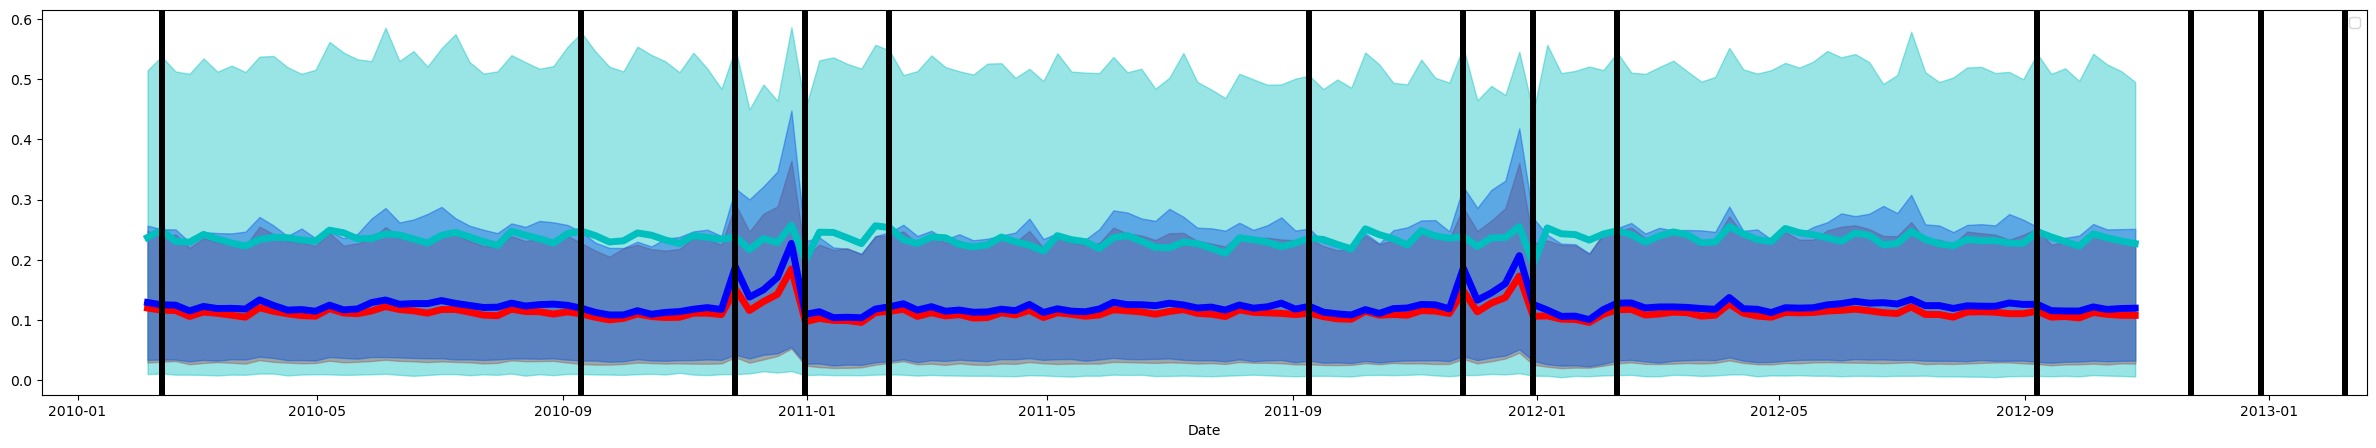

In [45]:
fig, ax = plt.subplots(figsize=(30, 5))

# Normalized by size of store
dates = np.unique(A_stores['Date'])
A_aggStats = A_stores.groupby('Date')['Weekly_Sales_by_Size'].agg(['mean', 'std', percentile(0.34), percentile(0.86)])
ax.plot(dates, A_aggStats['mean'], c='r', lw=5)
ax.fill_between(dates, y1=A_aggStats['percentile_34'], y2=A_aggStats['percentile_86'], color='r', alpha=0.4)
        
dates = np.unique(B_stores['Date'])
B_aggStats = B_stores.groupby('Date')['Weekly_Sales_by_Size'].agg(['mean', 'std', percentile(0.34), percentile(0.86)])
ax.plot(dates, B_aggStats['mean'], c='b', lw=5)
ax.fill_between(dates, y1=B_aggStats['percentile_34'], y2=B_aggStats['percentile_86'], color='b', alpha=0.4)

dates = np.unique(C_stores['Date'])
C_aggStats = C_stores.groupby('Date')['Weekly_Sales_by_Size'].agg(['mean', 'std', percentile(0.34), percentile(0.86)])
ax.plot(dates, C_aggStats['mean'], c='c', lw=5)
ax.fill_between(dates, y1=C_aggStats['percentile_34'], y2=C_aggStats['percentile_86'], color='c', alpha=0.4)

ax.legend(loc='best')
ax.set_xlabel('Date')
for holiday in holidayDates:
    ax.axvline(holiday, c='k', lw=3.)

 The above two plots show the averaged sales and sales normalized by size amongst stores labeled A, B, and C.  We can clearly observe (as we did in the first plot) that while Type A and B stores are larger, the sales by size of Type C are larger.  Additionally, while Type A and B stores have substantial bumps observed in their sales during the holiday season, Type C stores have sales that are relatively across the year.  It is possible that if Type C stores invested in potentially seasonal departments, they too could see a bump in the relative sales.  

## Departments 

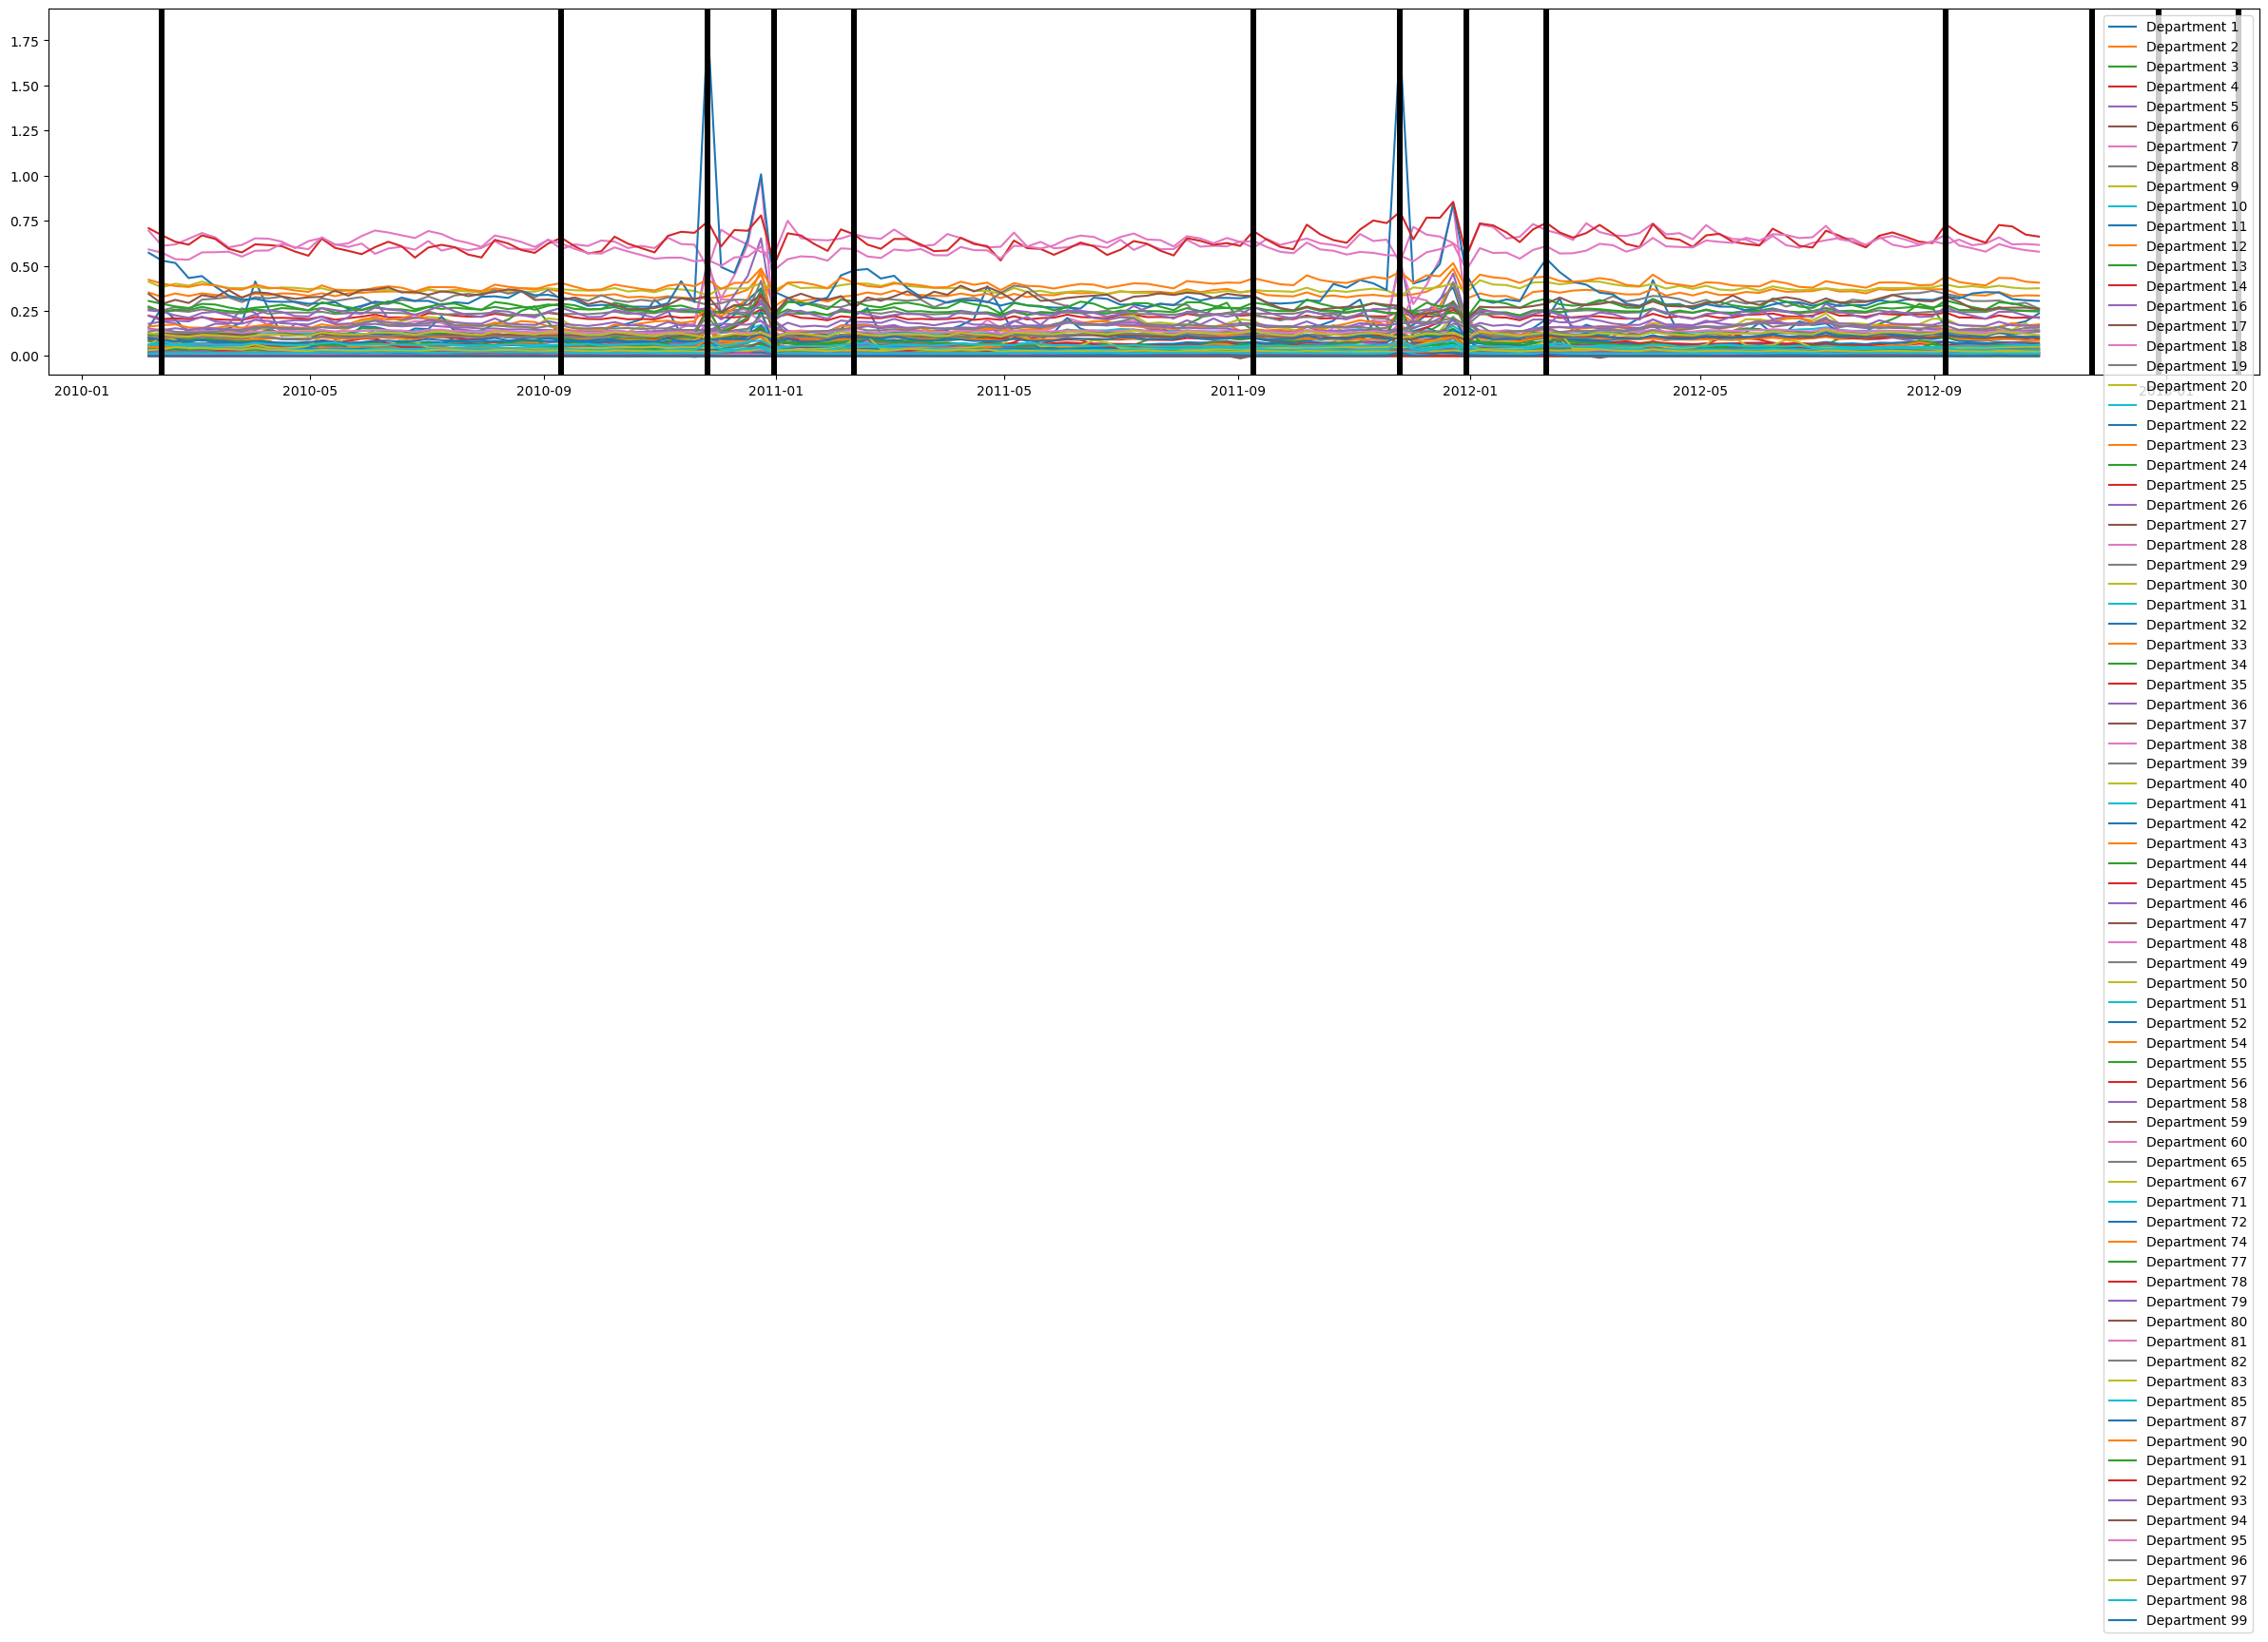

In [47]:
dates = np.unique(A_stores['Date'])
# print(sales_with_stores.columns)
dept_aggStats = sales_with_stores.groupby(['Date', 'Dept'])['Weekly_Sales_by_Size'].agg(['mean', 'std', percentile(0.34), percentile(0.86)]).reset_index()

fig, ax = plt.subplots(figsize=(30, 5))
for i in np.unique(dept_aggStats['Dept'].values):
    ax.plot(dept_aggStats['Date'].iloc[(dept_aggStats['Dept'] == i).values], dept_aggStats['mean'].iloc[(dept_aggStats['Dept'] == i).values], label=f'Department {i}')
ax.legend(loc='best')

for holiday in holidayDates:
    ax.axvline(holiday, c='k', lw=3.)

After aggregating the statistics amongst all the departments, the most noticeable feature is that some departments have stable sales across the year, whereas others have indications of spikes at certain periods.  These spikes are typically associated around the holiday season, which could mean that the sales from these departments are time-dependent.  The bumps that we see in those departments, are a clear indication that these departments are what are causing the increase in sales in Type A/B stores.  

Unique Departments: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 16 17 18 19 20 21 22 23 24 25
 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49
 50 51 52 54 55 56 58 59 60 65 67 71 72 74 77 78 79 80 81 82 83 85 87 90
 91 92 93 94 95 96 97 98 99]


Text(0, 0.5, 'P($N_{Dept}$)')

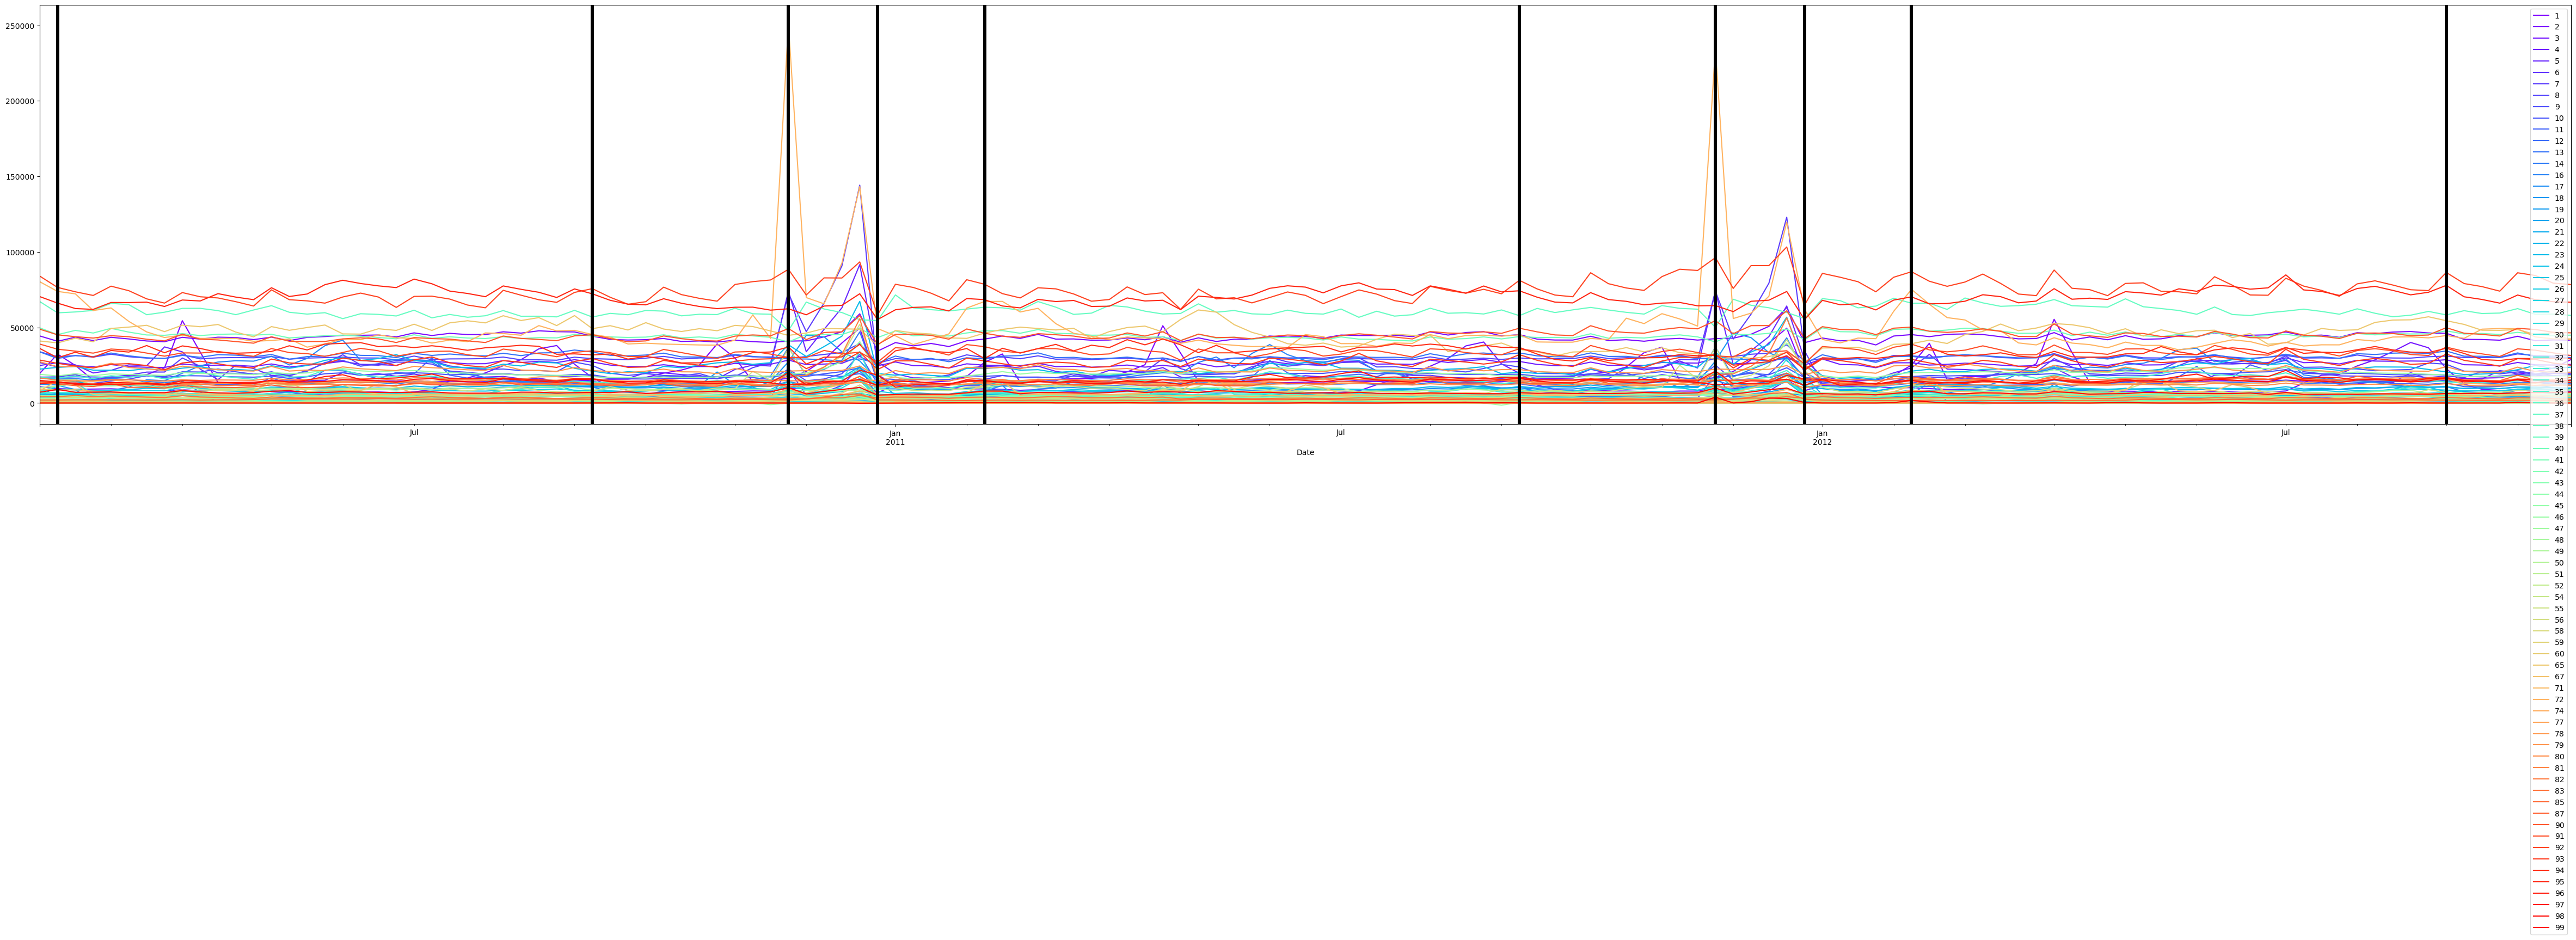

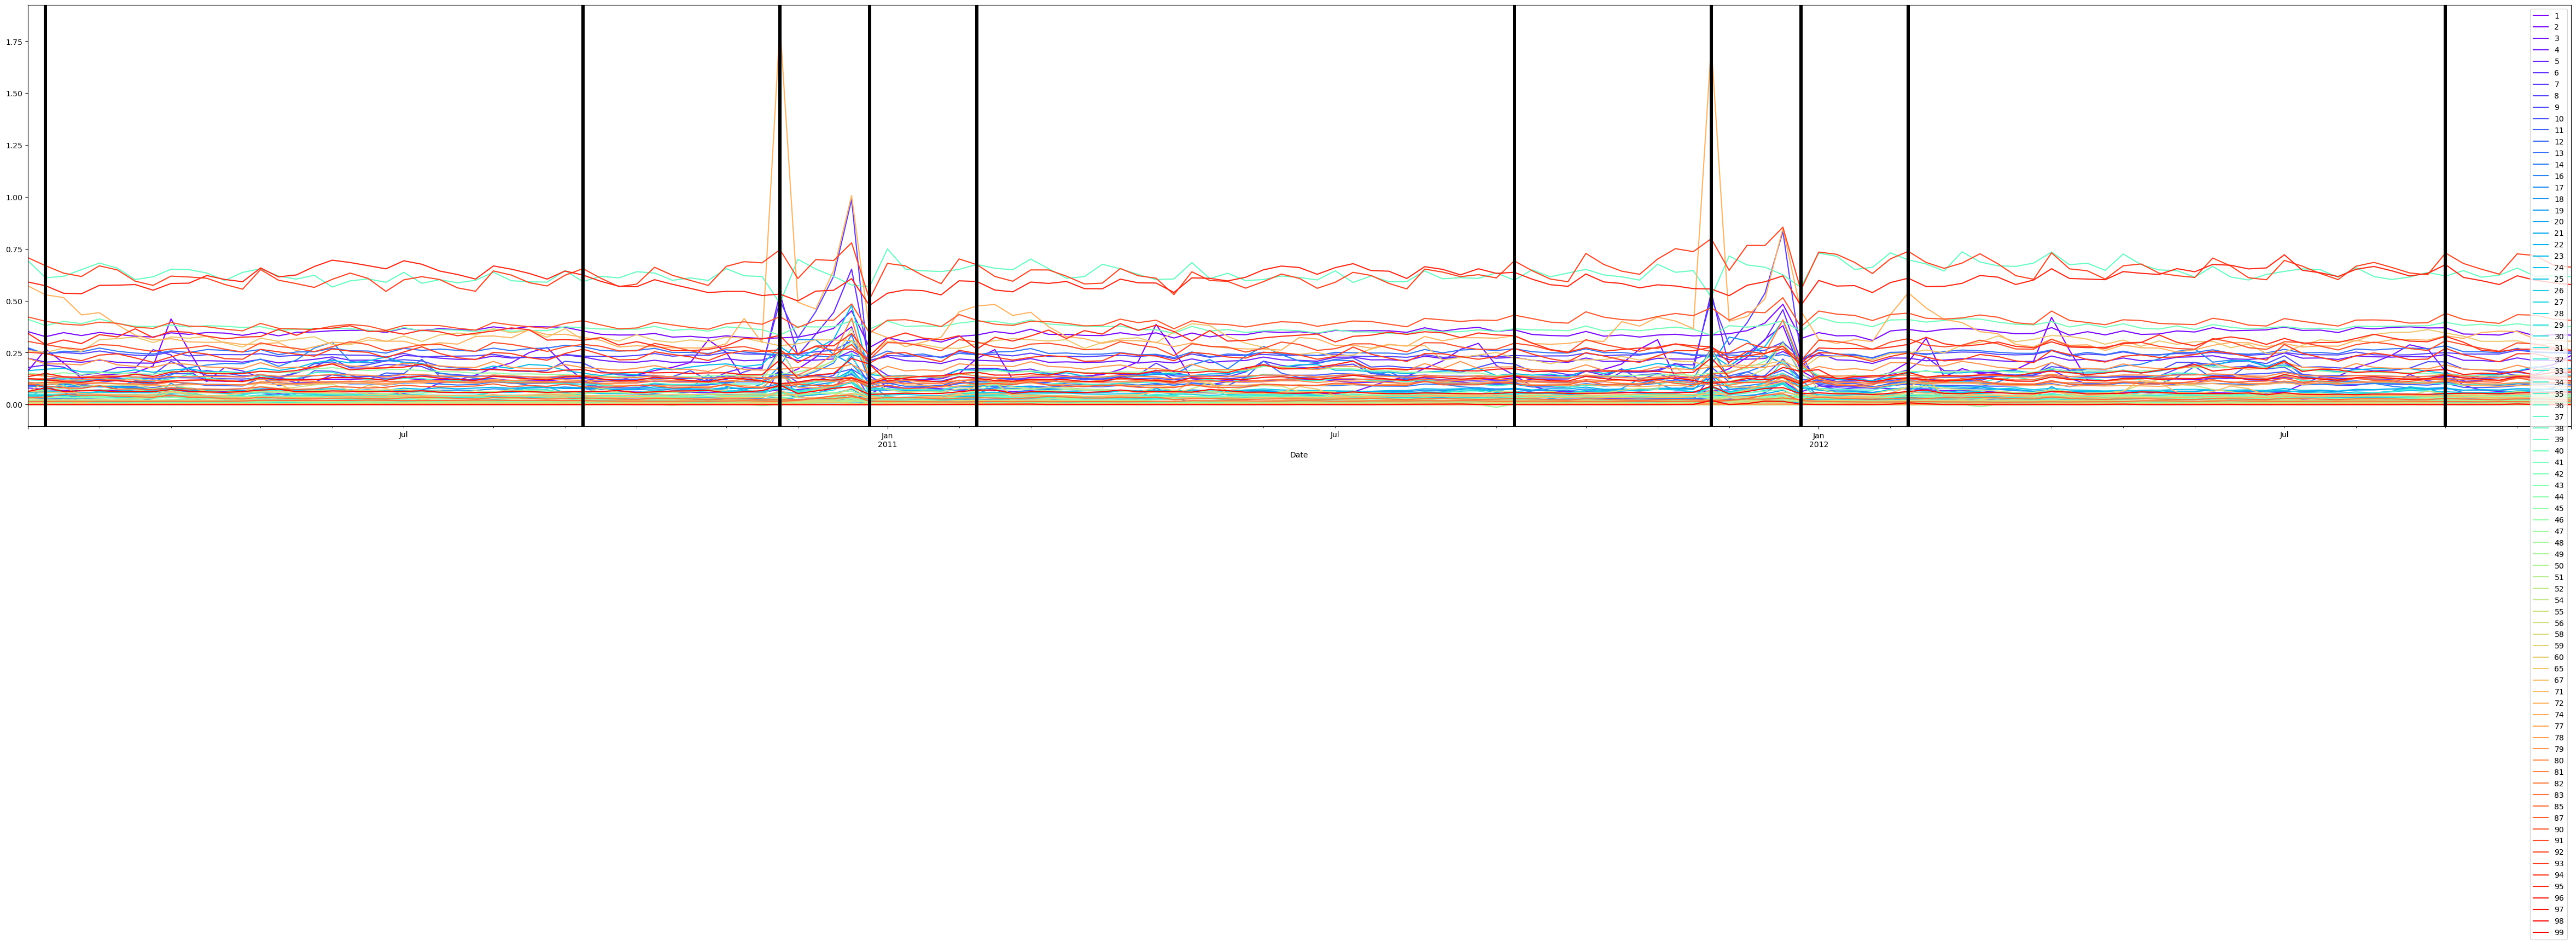

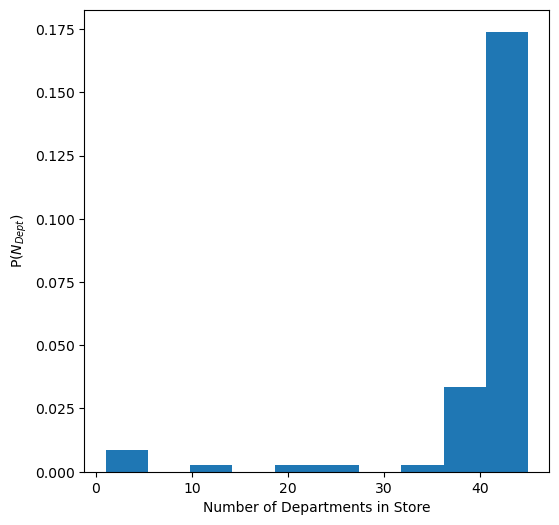

In [61]:
unique_depts = np.unique(sales_with_stores['Dept'])
print(f"Unique Departments: {unique_depts}")

fig, ax = plt.subplots(figsize=(60,10), sharex=True)

NDEPARTMENTS_PER_STORE = []
colors = cm.rainbow(np.linspace(0., 1., len(unique_depts)))
for dd, ud in enumerate(unique_depts):
    data = sales_with_stores.loc[sales_with_stores['Dept'] == ud]
    NDEPARTMENTS_PER_STORE.append(len(data.groupby('Store')['Weekly_Sales']))
    # print(f"Number of Stores with Department {ud}: {len(data.groupby('Store')['Weekly_Sales'])}")
    data.groupby('Date')['Weekly_Sales'].mean().plot(x='Date', y='Weekly_Sales', kind='line', color=colors[dd], label=ud, ax=ax)
    dept_mean = data.groupby('Store')['Weekly_Sales'].mean()

for holiday in holidayDates:
    ax.axvline(holiday, c='k', lw=3.)
ax.legend(loc='best')

fig, ax = plt.subplots(figsize=(60,10), sharex=True)
colors = cm.rainbow(np.linspace(0., 1., len(unique_depts)))
for dd, ud in enumerate(unique_depts):
    data = sales_with_stores.loc[sales_with_stores['Dept'] == ud]
    data.groupby('Date')['Weekly_Sales_by_Size'].mean().plot(x='Date', y='Weekly_Sales_by_Size', kind='line', color=colors[dd], label=ud, ax=ax)
    dept_mean = data.groupby('Store')['Weekly_Sales_by_Size'].mean()

for holiday in holidayDates:
    ax.axvline(holiday, c='k', lw=3.)


ax.legend(loc='best')

fig, ax = plt.subplots(figsize=(6,6))
ax.hist(NDEPARTMENTS_PER_STORE, density=True)
ax.set_xlabel('Number of Departments in Store')
ax.set_ylabel('P($N_{Dept}$)')

## External Features

In the cells above, what I have done is separate the stores based on their store ID, and then obtained the unique department IDs based on those stores.  This clearly shows that "type" of the store (A, B, C) is determined by the types of departments it contains.  A contains the most number of departments, while Type C stores contain the least number of departments.  This also could play a role in why Type C stores also have the lowest number of weekly sales, since they sell the least number of products.  But now the question we must answer is how do the sales between these stores compare over time with each other.  

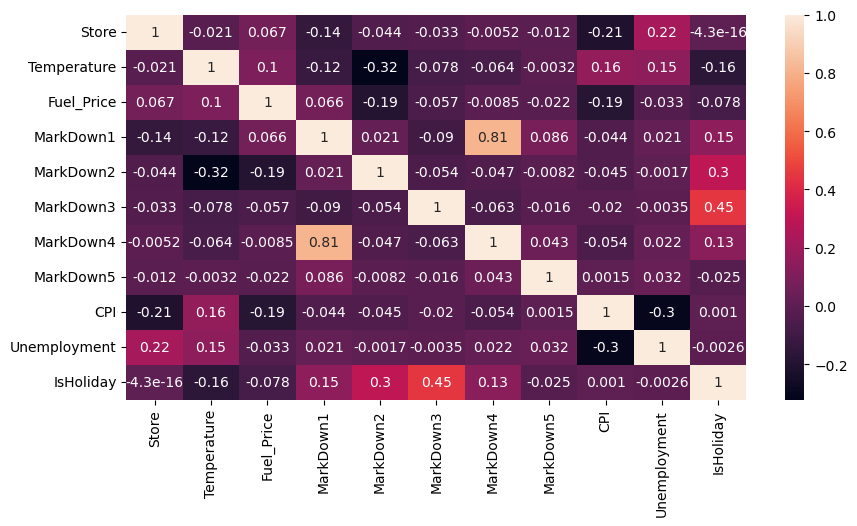

In [62]:
fig,ax = plt.subplots(1,figsize=(10,5))
ax=sns.heatmap(features.corr(numeric_only=True), annot=True, )

In the plot above, I show the correlation matrix between all the different features.  Most of these features are weakly, if not uncorrelated, with the other columns.  However, there are some particularly strong correlations between the markdowns with holidays and the Markdowns.  Markdowns 2 and 3 are mildly (relatively) to holidays, while Markdowns 1 and 4 are less strongly (but still notably) correlated with holidays as well.  Meanwhile Markdowns 1 and 4 are very strongly correlated with each other (correlation is 0.81).  However, temperature has a mild correlation with Markdown 2.  This is worth further investigation.  

In this next cell, we are going to extract the date and holiday data, since this data is unique compared to the others, which are numeric based. 

Text(0, 0.5, 'P(Markdown)')

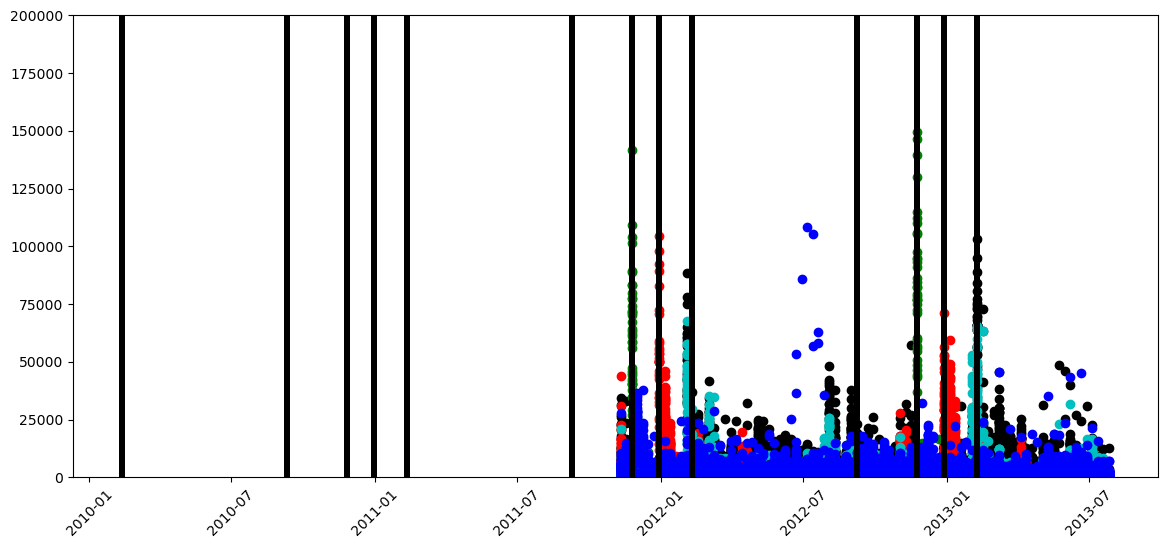

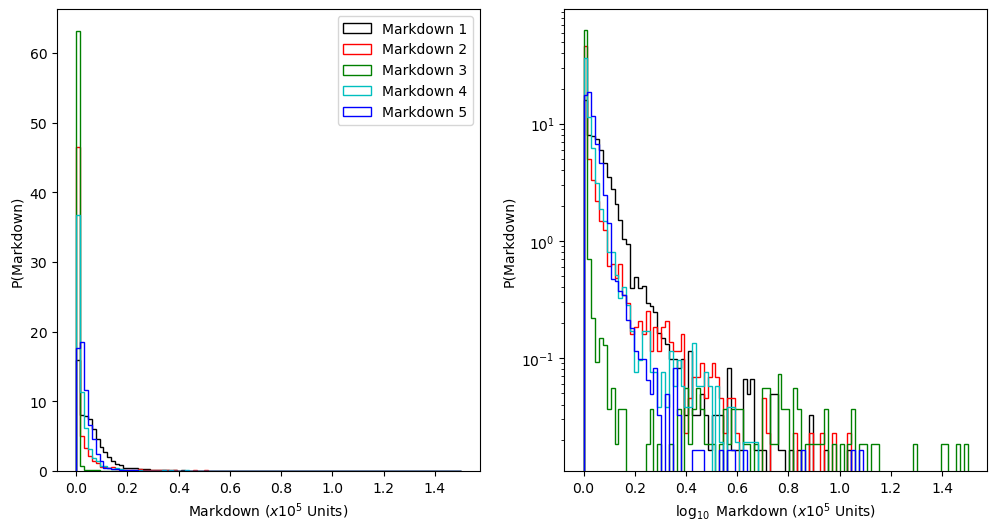

In [63]:
fig, ax = plt.subplots(figsize=(14, 6))

Markdown1_IND = ~features['MarkDown1'].isna().values
Markdown2_IND = ~features['MarkDown2'].isna().values
Markdown3_IND = ~features['MarkDown3'].isna().values
Markdown4_IND = ~features['MarkDown4'].isna().values
Markdown5_IND = ~features['MarkDown5'].isna().values


for holiday in holidayDates:
    ax.axvline(holiday, c='k', lw=3.)
    
ax.scatter(features['Date'][Markdown1_IND], features['MarkDown1'][Markdown1_IND], c='k', label='Markdown 1')
ax.scatter(features['Date'][Markdown2_IND], features['MarkDown2'][Markdown2_IND], c='r', label='Markdown 2')
ax.scatter(features['Date'][Markdown3_IND], features['MarkDown3'][Markdown3_IND], c='g', label='Markdown 3')
ax.scatter(features['Date'][Markdown4_IND], features['MarkDown4'][Markdown4_IND], c='c', label='Markdown 4')
ax.scatter(features['Date'][Markdown5_IND], features['MarkDown5'][Markdown5_IND], c='b', label='Markdown 5')

plt.xticks(rotation=45)

ax.set_ylim(0., 200000.)

fig, ax = plt.subplots(figsize=(12, 6), ncols=2)
bins = np.linspace(0, 1.5, 100)

ax[0].hist(features['MarkDown1'][Markdown1_IND]/1E5, bins=bins, histtype='step', density=True, color='k', label='Markdown 1')
ax[0].hist(features['MarkDown2'][Markdown2_IND]/1E5, bins=bins, histtype='step', density=True, color='r', label='Markdown 2')
ax[0].hist(features['MarkDown3'][Markdown3_IND]/1E5, bins=bins, histtype='step', density=True, color='g', label='Markdown 3')
ax[0].hist(features['MarkDown4'][Markdown4_IND]/1E5, bins=bins, histtype='step', density=True, color='c', label='Markdown 4')
ax[0].hist(features['MarkDown5'][Markdown5_IND]/1E5, bins=bins, histtype='step', density=True, color='b', label='Markdown 5')

ax[0].legend(loc='best')
ax[0].set_xlabel(f'Markdown ($x10^5$ Units)')
ax[0].set_ylabel('P(Markdown)')

ax[1].hist(features['MarkDown1'][Markdown1_IND]/1E5, bins=bins, histtype='step', density=True, color='k')
ax[1].hist(features['MarkDown2'][Markdown2_IND]/1E5, bins=bins, histtype='step', density=True, color='r')
ax[1].hist(features['MarkDown3'][Markdown3_IND]/1E5, bins=bins, histtype='step', density=True, color='g')
ax[1].hist(features['MarkDown4'][Markdown4_IND]/1E5, bins=bins, histtype='step', density=True, color='c')
ax[1].hist(features['MarkDown5'][Markdown5_IND]/1E5, bins=bins, histtype='step', density=True, color='b')

ax[1].set_yscale('log')
ax[1].set_xlabel('$\log_{10}$ Markdown ($x10^5$ Units)')
ax[1].set_ylabel('P(Markdown)')

## Markdowns and Holidays

In these sets of plots we explore the Markdown and Holiday features of the data set.  In the first plot we can observe that markdowns begin in 2012 and continue into 2013, and not before then, which is an interesting feature of the dataset.  This could indicate a change in marketing schemes during 2012.  However, once the markdowns are incorporated into the business structure, they are highly correlated with periods associated with holidays and times of increased activity.  Typically almost every holiday observed, sees a corresponding spike in one of the 5 markdowns. This means that while we currently might not be able to use the actual sizes of the Markdowns themselves in our training, we could attempt to use the weeks around holidays to create market predictors. 

We also observe that Markdowns 1 and 4 happen all year round, whereas markdowns 2 and 3 are occur between November-January, which is typically associated with the winter holiday months (associated with Thanksgiving, Black Friday, Christmas, and New Years).  

## Other Features

Now lets plot the time series distributions of the other features.  These features include the temperature, fuel price, CPI (consumer price index), and the unemployment rate.    

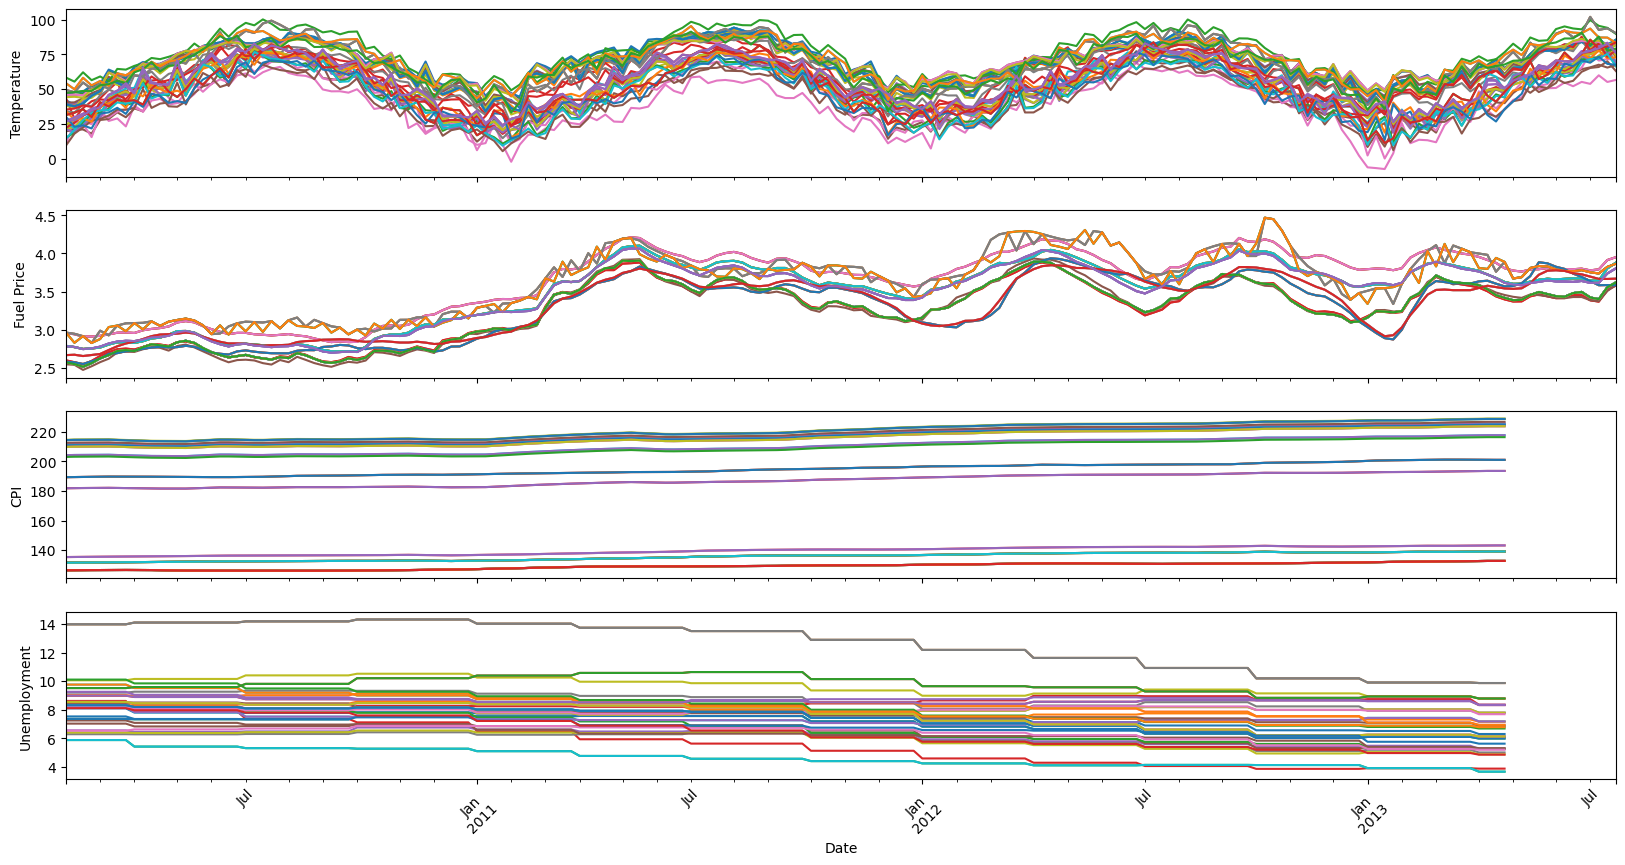

In [64]:
fig,ax=plt.subplots(figsize=(20,10), nrows = 4,sharex=True)
features.groupby("Store").plot(kind="line", x="Date", y="Temperature", ax=ax[0], rot=45, legend=False)
features.groupby("Store").plot(kind="line", x="Date", y="Fuel_Price", ax=ax[1], rot=45, legend=False)
features.groupby("Store").plot(kind="line", x="Date", y="CPI", ax=ax[2], rot=45, legend=False)
features.groupby("Store").plot(kind="line", x="Date", y="Unemployment", ax=ax[3], rot=45, legend=False)

ax[3].set_xlabel('Date')
ax[0].set_ylabel('Temperature')
ax[1].set_ylabel('Fuel Price')
ax[2].set_ylabel('CPI')
ax[3].set_ylabel('Unemployment')
plt.show()

There is a clear seasonal fluctuations in the temperature and fuel prices (which is unsurprising).  Additionally, there is a linear increase in the CPI (consumer price index), a linear decrease in the unemployment rate, and what appears to be an increase in the fuel prices year-over-year.

In the above plot, we can clearly observe that different departments are driving the fluctuations in the sales.  There are a few departments that observe a very strong spike in sales especially during the holiday seasons, while some other departments tend to have very stable sales across the year, with very little changes.  Hence, we can conclude it is the department sales which cause the differences in the sales, not the store type (but the type DOES impact the magnitude of sales being made). 

## Comparing the Sales

After we compare the sales between "Store" types and "Department" types, it appears that Departments drive the fluctuations in price.  This conclusion is motivated the fluctuations observed in the departmental sales variations.  In the summary plot showing the distribution of sales by Store type correlate strongly with flucutations between the departments, but the variations between the Store types themselves (comparing sales between stores of Type A, B, and C) are not substantially different from each other. In essence, if I randomly selected a store of Type A, B, or C, I likely would not be able to tell from which Store Type the store came from except through the magnitue of sales.  However, if I randomly select a department, there is a good likelihood that I would select a specific department.  

# Business Case 

I am now going to be working on a business case: I have a entrepaneur who wants to open up a store, and they want to open up a store, that will optimize profits.  The questions becomes should they open a store of Type A, B, or C, or can they open up a hybrid store with a combination of different departments? Well of course, part of these costs will be driven by the timing of sales, and the size of the stores as well, but for all intents and purposes, let us assume that the "size" of the store is a proxy for maintenance costs (more costumers could mean more costs in maintenance of the store, larger bulk purchaseses, more left over items, etc.).  With this my goal, is to maximize the amount of money per department per unit size.  

In [85]:
dept_aggStats = sales_with_stores.groupby(['Date', 'Dept'])['Weekly_Sales_by_Size'].agg(['mean', 'std', percentile(0.34), percentile(0.86)]).reset_index()
depts = np.unique(sales_with_stores['Dept'].values, return_counts=True)[0]

for dept in depts:
    deptList = sales_with_stores[sales_with_stores['Dept'] == dept]
    print(len(deptList), np.unique(deptList['Store'].values))

6435 [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45]
6435 [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45]
6435 [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45]
6435 [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45]
6347 [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45]
5986 [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45]
6435 [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45]

# Building the Model

Let us now begin building our predictive models.  To accomplish this goal, let us gather everything together that we have learned.  

1. It appears that the fluctuations in weekly sales between departments drive the fluctuations in the stores, while store type does not appear as critical to model.  To this end, we are going to join all our data on department types rather than store types.
2. Fuel prices and temperatures display some seasonality in their distributions
3. Markdowns and Holiday periods are highly correlated with each other, but markdowns only appear in the tail end 2011.  This will be a problem because 
4. CPI and Unemployment are inversely correlated with each other, however it does not seem to correlate with any aspect of sales.  

I am now going to merge the sales and feature dataframes together, the question now is which are the most likely to be helpful with learning.  From our analysis, it looks like we want to merge the features with the sales database by joining on the stores.  For the purposed of this Notebook I will select:

1. Department
2. Sales
3. Dates
4. Temperature 
5. Fuel
6. IsHoliday 

In [ ]:
features_merge = features.drop(columns=['IsHoliday', 'MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5', 'CPI', 'Unemployment'])

print(features_merge.dtypes)
print(sales.dtypes)

features_merge['Date'] = pd.to_datetime(features_merge['Date'], format="%Y/%m/%d")
sales['Date'] = pd.to_datetime(sales['Date'], format="%Y/%m/%d")
merged_df = pd.merge(sales, features_merge, on=['Store', 'Date'], how='inner')

unique_StoreID = np.unique(merged_df["Store"])
unique_DeptID = np.unique(merged_df["Dept"])

print("It appears that not all departments at all stores seemingly have the same number of dates, but it would make sense that if those date of sales do not exist, the totalling accounting would be $0.  But for simplicity, let here let's drop them out. ")
print(f"Number of Stores/Departments before cleanup: {len(merged_df)}")
for storeID in unique_StoreID:
    for deptID in unique_DeptID:
        store_dat = merged_df.loc[np.logical_and(merged_df['Store'] == storeID, merged_df['Dept'] == deptID)]
        # print(f"Length of Store {storeID} Department {deptID}: {len(merged_df.loc[np.logical_and(merged_df['Store'] == storeID, merged_df['Dept'] == deptID)])}")
        if len(store_dat) != 143: 
            # print(f"We should delete Store {storeID} Department {deptID}")
            merged_df = merged_df.loc[~((merged_df['Store'] == storeID) & (merged_df['Dept'] == deptID))]
            
print(f"Number of Stores/Departments after cleanup: {len(merged_df)}")


It appears we got rid of approximately 15% of our rows in the dataset, which is not great.  A better strategy (although substantially more complicated and time intensive) would be to impute the missing data with $0 weekly sales, while appending the temperature, prices, and markdowns from the other columns.  But this would also require a substantial effort for what is meant to be a demonstration.  

90    2011-10-28
91    2011-11-04
92    2011-11-11
93    2011-11-18
94    2011-11-25
95    2011-12-02
96    2011-12-09
97    2011-12-16
98    2011-12-23
99    2011-12-30
100   2012-01-06
101   2012-01-13
102   2012-01-20
103   2012-01-27
104   2012-02-03
105   2012-02-10
106   2012-02-17
107   2012-02-24
108   2012-03-02
109   2012-03-09
Name: Date, dtype: datetime64[ns]
        Store  Dept       Date  Weekly_Sales  IsHoliday  Temperature  \
0           1     1 2010-02-05      24924.50      False        42.31   
1           1     1 2010-02-12      46039.49       True        38.51   
2           1     1 2010-02-19      41595.55      False        39.93   
3           1     1 2010-02-26      19403.54      False        46.63   
4           1     1 2010-03-05      21827.90      False        46.50   
...       ...   ...        ...           ...        ...          ...   
421430     45    97 2012-09-28       6269.73      False        64.88   
421431     45    97 2012-10-05       6573.18      

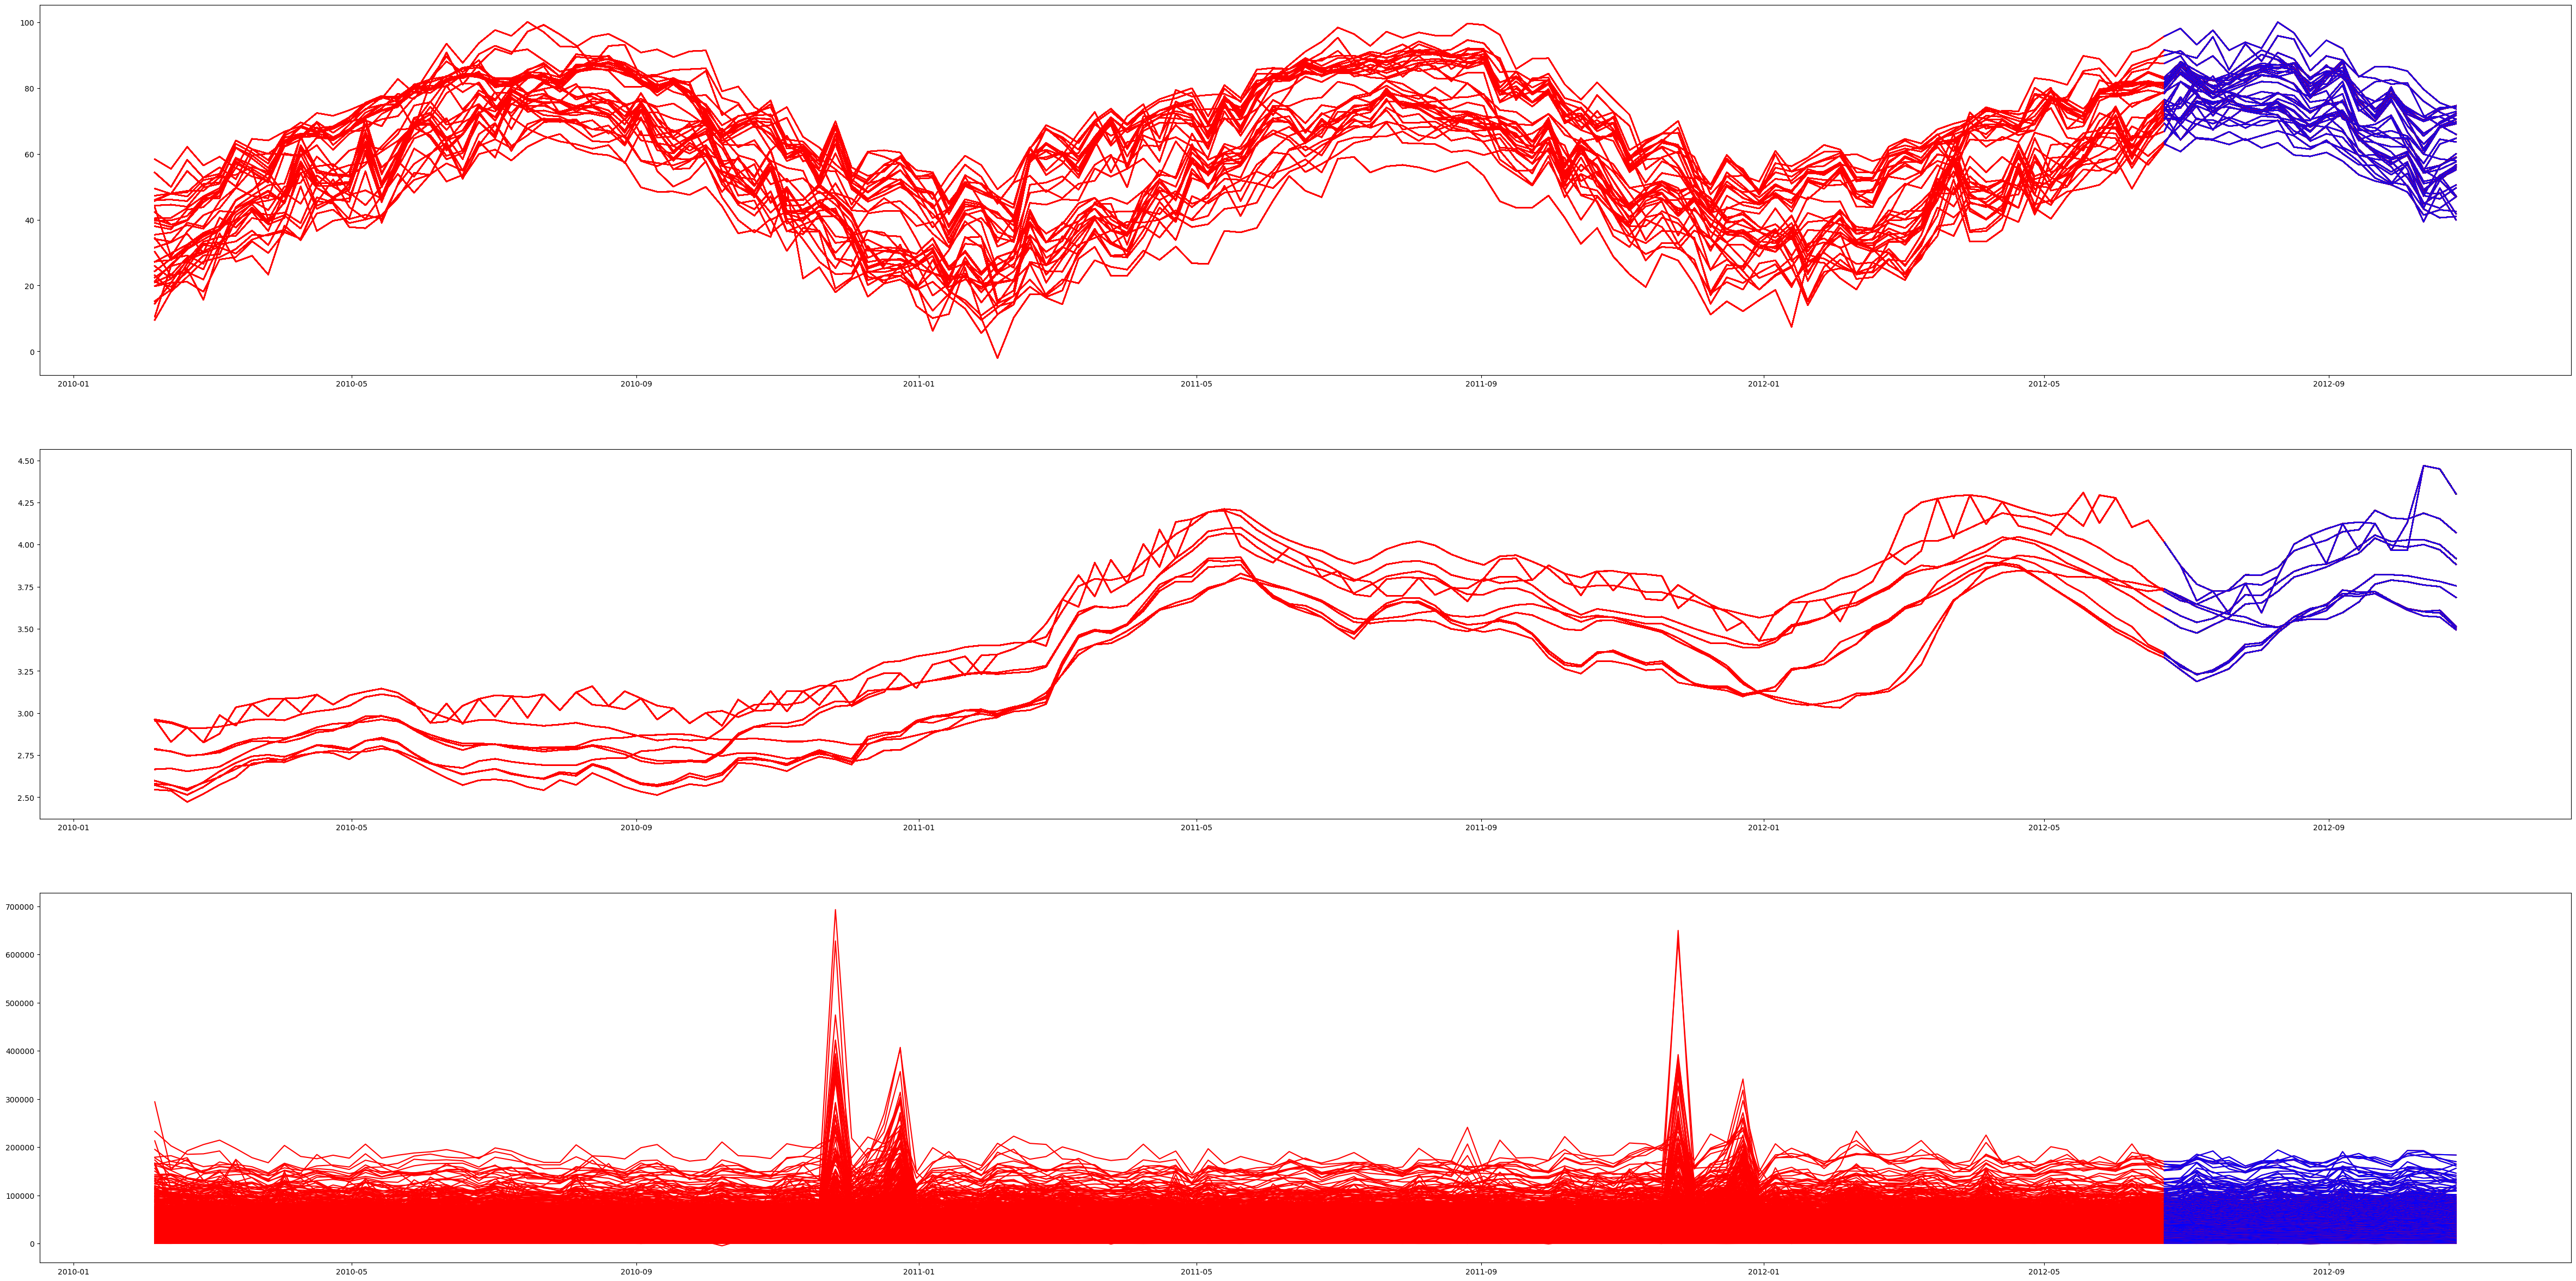

In [20]:
# Let's split our data into training and test sets 
print(merged_df['Date'][90:110])
SELECTED_DATE = '2012-6-21'
# SPLIT_IND = np.where(merged_df['Date'] <= '2011-10-21')
# train_df = merged_df[merged_df['Date'] <= '2011-10-21']
# test_df = merged_df[np.logical_and('2011-10-21' <= merged_df['Date'], merged_df['Date'] < '2012-10-26')]
SPLIT_IND = np.where(merged_df['Date'] <= SELECTED_DATE)
train_df = merged_df # [merged_df['Date'] <= SELECTED_DATE]
test_df = merged_df[np.logical_and(SELECTED_DATE <= merged_df['Date'], merged_df['Date'] < '2012-11-26')]


print(train_df)
print(test_df)
print("Finished splitting the data")
fig, ax = plt.subplots(figsize=(60, 30), nrows=3)


for storeID in unique_StoreID:

    # Selecting a few departments to plot
    for deptID in unique_DeptID:

        # if deptID != 1 and deptID != 10 and deptID != 20 and deptID != 30: continue 
        train_dat = train_df.loc[np.logical_and(train_df['Store'] == storeID, train_df['Dept'] == deptID)] 
        test_dat = test_df.loc[np.logical_and(test_df['Store'] == storeID, test_df['Dept'] == deptID)] 
        ax[0].plot(train_dat['Date'], train_dat['Temperature'], c='r')
        ax[0].plot(test_dat['Date'], test_dat['Temperature'], c='b')

        ax[1].plot(train_dat['Date'], train_dat['Fuel_Price'], c='r')
        ax[1].plot(test_dat['Date'], test_dat['Fuel_Price'], c='b')

        ax[2].plot(train_dat['Date'], train_dat['Weekly_Sales'], c='r')
        ax[2].plot(test_dat['Date'], test_dat['Weekly_Sales'], c='b')
        # print(store_Dept)




The above plot shows the data which we are including in our training (red) and validation/test (blue).  These data are plotted for all the stores and the departments contained within.  For the rest of this notebook, I am going to use the example of StoreID=1 and DepartmentID=1.  I will likely also then do some tests where I group together the analysis for the stores, and then for the departments.  

In [21]:
subtrain_df = train_df.loc[np.logical_and(train_df['Store'] == 1, train_df['Dept'] == 1)] 
subtest_df = test_df.loc[np.logical_and(test_df['Store'] == 1, test_df['Dept'] == 1)] 
# print(subtrain_df)
# print(subtest_df)

X_train = subtrain_df.copy()
X_test = subtest_df.copy()
X_train = X_train # .drop('Weekly_Sales', axis=1)
X_test = X_test # .drop('Weekly_Sales', axis=1)
# print(X_train, X_test)

y_train = subtrain_df['Weekly_Sales'].values
y_test = subtest_df['Weekly_Sales'].values

# Time Series Analysis

Our data for weekly sales, temperature, and fuel costs are all time series data, so it might be a good thing to check out some of the simpler time series data analysis techniques like VAR (Vector Auto-Regression and SARIMA (seasonal auto-regression integrated mean average).  

The first step for using auto-regression will always first to check whether our data is stationary or not.  Stationary refers to a non-vayring mean for our data.  This is important for our time series data to be stationary because it will allow the model to more accurately sift out the features, rather than being dominated by trends in the data.  Stationary data also leads to more interpretable data and accurate results.  

In [22]:
!pip install statsmodels

In [23]:
from statsmodels.tsa.stattools import adfuller

def adf_test(ts, signif=0.05):
    
    adf_test = adfuller(ts, autolag='AIC')
    # Outputs of Augmented Dickey-Fuller Test
    # 1: p-value (< significance means we reject the Null hypothesis which is that the distributions is NOT stationary, 
                # if > significance then we fail to reject the Null Hypothesis) 
    print(adf_test)
    
    p = adf_test[1]
    if p <= signif:
        print(f"Series is Stationary")
        return True
    else:
        print(f"Series is Non-Stationary")
        return False
#apply adf test on the series
adf_test(y_train)

(-2.5221638686500367, 0.11017432282586997, 6, 136, {'1%': -3.4793722137854926, '5%': -2.8830370378332995, '10%': -2.578233635380623}, 2638.475060753871)
Series is Non-Stationary


False

In [24]:
from statsmodels.tsa.vector_ar.var_model import VAR

Xtrain_VAR = X_train.set_index('Date')
Xtest_VAR = X_test.set_index('Date')

Xtrain_VAR = Xtrain_VAR.drop(['Store', 'Dept'], axis=1)
Xtest_VAR = Xtest_VAR.drop(['Store', 'Dept'], axis=1)

Xtrain_VAR['IsHoliday'] = Xtrain_VAR['IsHoliday'].astype(int)
Xtest_VAR['IsHoliday'] = Xtest_VAR['IsHoliday'].astype(int)
print(Xtest_VAR['IsHoliday'])
print(Xtrain_VAR.dtypes, "\n", Xtest_VAR.dtypes)

model = VAR(endog=Xtrain_VAR.values)
results = model.fit()

Date
2012-06-22    0
2012-06-29    0
2012-07-06    0
2012-07-13    0
2012-07-20    0
2012-07-27    0
2012-08-03    0
2012-08-10    0
2012-08-17    0
2012-08-24    0
2012-08-31    0
2012-09-07    1
2012-09-14    0
2012-09-21    0
2012-09-28    0
2012-10-05    0
2012-10-12    0
2012-10-19    0
2012-10-26    0
Name: IsHoliday, dtype: int64
Weekly_Sales    float64
IsHoliday         int64
Temperature     float64
Fuel_Price      float64
dtype: object 
 Weekly_Sales    float64
IsHoliday         int64
Temperature     float64
Fuel_Price      float64
dtype: object


In [25]:
results.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Wed, 25, Jun, 2025
Time:                     12:40:45
--------------------------------------------------------------------
No. of Equations:         4.00000    BIC:                    13.3529
Nobs:                     142.000    HQIC:                   13.1058
Log likelihood:          -1704.46    FPE:                    415298.
AIC:                      12.9366    Det(Omega_mle):         361613.
--------------------------------------------------------------------
Results for equation y1
           coefficient       std. error           t-stat            prob
------------------------------------------------------------------------
const     24564.706994      6420.135923            3.826           0.000
L1.y1         0.428016         0.076487            5.596           0.000
L1.y2      2399.050452      2643.989002            0.907           0.364
L1.y3      -188.542851

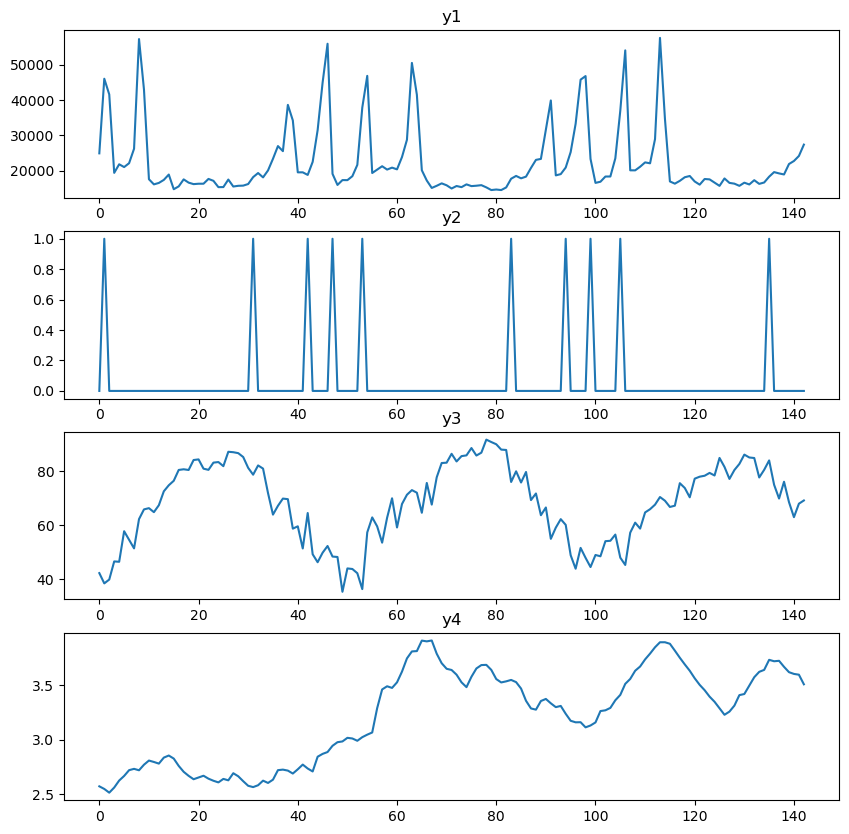

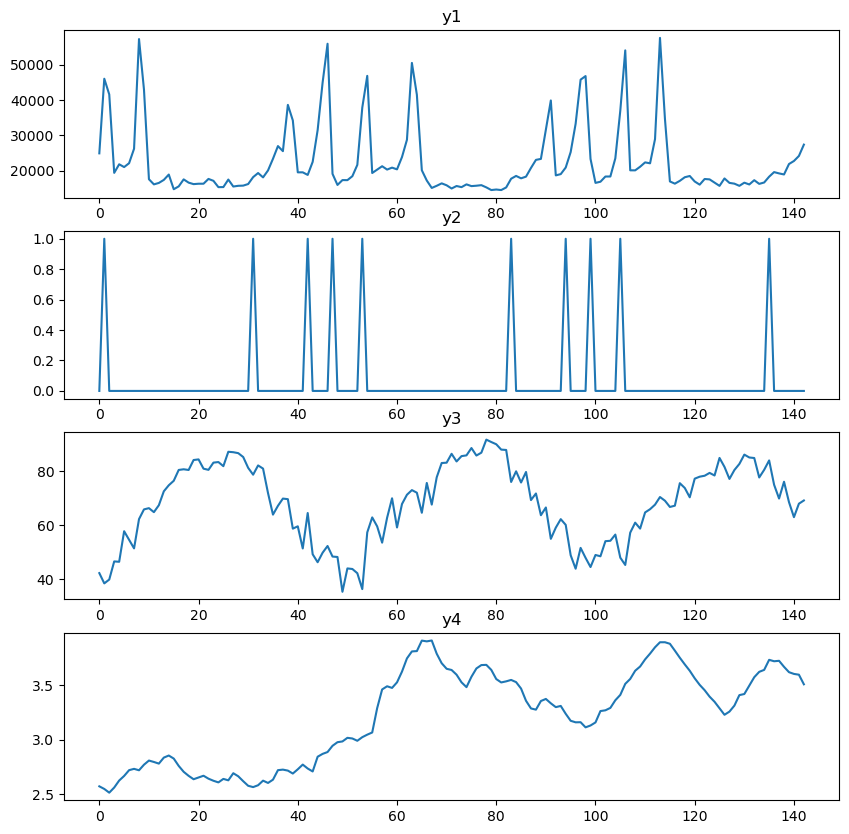

In [26]:
results.plot()

Weekly_Sales    float64
IsHoliday         int64
Temperature     float64
Fuel_Price      float64
dtype: object Weekly_Sales    float64
IsHoliday         int64
Temperature     float64
Fuel_Price      float64
dtype: object
[[2.43590414e+04 6.91809021e-02 6.95641855e+01 3.51215613e+00]
 [2.31531071e+04 5.72588739e-02 6.99125651e+01 3.51578299e+00]
 [2.25438102e+04 5.64534530e-02 7.02836479e+01 3.51880193e+00]
 [2.22120801e+04 5.49118579e-02 7.06364374e+01 3.52126195e+00]
 [2.20006589e+04 5.37806894e-02 7.09646283e+01 3.52329798e+00]
 [2.18462202e+04 5.27946338e-02 7.12659890e+01 3.52497378e+00]
 [2.17214637e+04 5.19279381e-02 7.15411060e+01 3.52633462e+00]
 [2.16145462e+04 5.11548176e-02 7.17914769e+01 3.52741498e+00]
 [2.15200655e+04 5.04619772e-02 7.20188927e+01 3.52824376e+00]
 [2.14353489e+04 4.98401768e-02 7.22251689e+01 3.52884620e+00]
 [2.13588960e+04 4.92823388e-02 7.24120432e+01 3.52924493e+00]
 [2.12897270e+04 4.87825349e-02 7.25811400e+01 3.52946044e+00]
 [2.12271088e+04 4.83355

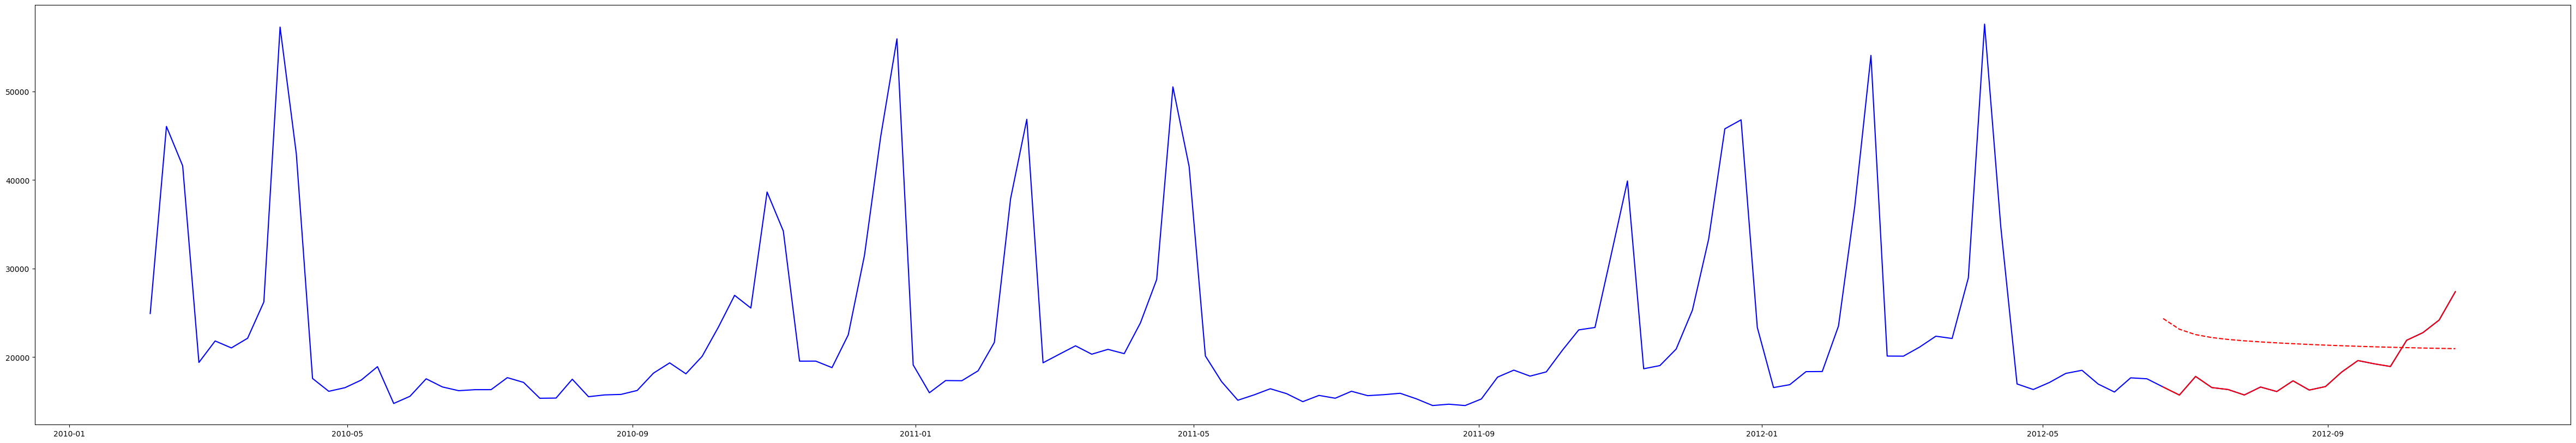

In [27]:
print(Xtrain_VAR.dtypes, Xtest_VAR.dtypes)
pred = results.forecast(Xtest_VAR.values, steps=len(Xtest_VAR.values))

print(pred)

fig, ax = plt.subplots(figsize=(60,10))

ax.plot(Xtrain_VAR.index, y_train, '-b')
ax.plot(Xtest_VAR.index, y_test, '-r')
ax.plot(Xtest_VAR.index, pred[:,0], '--r')

We completely miss all the peaks that come from the holidays, and this clearly does not capture the features required to be an adequate model.  The peaks, which we know are correlated with the holiday season are season features, and so I am going to try and use SARIMA, which is an extention of ARIMA (where the S stands for seasonality).  

The first step is to find the optimal parameters for our SARIMA model which require 7 parameters: p, q, d, P, Q, D, S.  The lower (non-seasonal) and upper (seasonal) case letters represent the orders the AR (p/P), MA (q/Q), Integrated quantities (d/D), and seasonal period (S).  Since we have weekly data our seasonal variations will occur on a weekly basis 

In [ ]:
import itertools
from itertools import product
from statsmodels.tsa.statespace.sarimax import SARIMAX

%pip install pmdarima
from pmdarima import auto_arima

# Fit an auto ARIMA model
model = auto_arima(
    Xtrain_VAR['Weekly_Sales'],
    start_p=1, max_p=4,
    start_q=1, max_q=4,
    d=1,  # Set to None for auto-differencing
    seasonal=True,
    start_P=2, max_P=4,
    start_Q=2, max_Q=4,
    D=1,
    m=52,  # Seasonal period (e.g., 52 for weekly data)
    trace=True,  # Print search progress
    error_action='ignore',
    suppress_warnings=True,
    stepwise=True,  # Stepwise search to reduce computation time
    n_jobs=-1  # Parallelize search
)

# Print the best ARIMA and seasonal orders
print("Best p, d, q order:", model.order)
print("Best seasonal P, D, Q, m order:", model.seasonal_order)

# Access the AIC of the model
print("Best AIC:", model.aic())
print("Best Parameters:", model.get_params())

Note: you may need to restart the kernel to use updated packages.
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(2,1,2)[52]             : AIC=1875.466, Time=102.92 sec
 ARIMA(0,1,0)(0,1,0)[52]             : AIC=1904.309, Time=0.34 sec
 ARIMA(1,1,0)(1,1,0)[52]             : AIC=1879.664, Time=3.76 sec
 ARIMA(0,1,1)(0,1,1)[52]             : AIC=inf, Time=7.33 sec
 ARIMA(1,1,1)(1,1,2)[52]             : AIC=inf, Time=147.77 sec


In [ ]:
# From the above info it appears the best fit parameters are (3, 1, 2) and (1, 1, 0, 52), but after some deeper digging 
# it seems that the best fit data is actually (3, 1, 3) and (0, 1, 0)
# model = SARIMAX(y_train, order=(3, 1, 3), seasonal_order=(0, 1, 0, 52), enforce_stationarity = False )
# model = SARIMAX(y_train, order=(3, 1, 2), seasonal_order=(1, 1, 0, 52), )
model = SARIMAX(y_train, order=(0, 1, 0), seasonal_order=(0, 1, 1, 4), )
model_LC = SARIMAX(y_train, order=(1, 1, 3), seasonal_order=(0, 1, 1, 52), simple_differencing=False, enforce_stationarity = False) # From Lydia Elias & Corey Kownacki

result = model.fit()
result_LC = model_LC.fit()
# result_3 = model_3.fit()
# print(result.summary())


# Get the model's lag structure
p = result.model_orders['ar']  # AR terms
q = result.model_orders['ma']  # MA terms
P = 0 #result.model_seasonal_orders['ar']  # Seasonal AR terms
Q = 0 # result.model_seasonal_orders['ma']  # Seasonal MA terms
s = 52 # result.model_seasonal_orders['period']  # Seasonal period


# Get the model's lag structure
p_LC = result_LC.model_orders['ar']  # AR terms
q_LC = result_LC.model_orders['ma']  # MA terms
P_LC = 0 # result_LC.model_seasonal_orders['ar']  # Seasonal AR terms
Q_LC = 1 # result_LC.model_seasonal_orders['ma']  # Seasonal MA terms
s_LC = 52 # result_LC.model_seasonal_orders['period']  # Seasonal period

print(f"The total number of lags required by the model: {max(p+P*s, q+Q*s)}")
print(f"The total number of lags required by the model: {max(p_LC+P_LC*s_LC, q_LC+Q_LC*s_LC)}")

In [ ]:
print(len(y_train)+100)

pred = result.get_forecast(len(y_test))
pred_LC = result_LC.get_forecast(len(y_test))

fig, ax = plt.subplots(figsize=(60, 10))
ax.plot(Xtrain_VAR.index, y_train, '-b', lw=4)
ax.plot(Xtest_VAR.index, y_test, '-g', lw=4)

ax.plot(Xtest_VAR.index, pred.predicted_mean, '-r', lw=4)
ax.fill_between(Xtest_VAR.index, y1=pred.conf_int()[:,0], y2=pred.conf_int()[:,1], color='r', alpha=0.2)

ax.plot(Xtest_VAR.index, pred_LC.predicted_mean, '-c', lw=4)
ax.fill_between(Xtest_VAR.index, y1=pred_LC.conf_int()[:,0], y2=pred_LC.conf_int()[:,1], color='c', alpha=0.2)
# ax.plot(Xtest_VAR.index, pred_2, '--r')
# ax.plot(Xtest_VAR.index, pred_2, '-.r')

result.plot_diagnostics()
result_LC.plot_diagnostics()

## The Other Variables

One thing of particular note is that till yet I have not used the other predictor variables (temperature, fuel price, and holiday dates) in order to predict the price.  

In [ ]:
# Fit an auto ARIMA model
best_Temp = auto_arima(
    X_train['Temperature'],
    start_p=0, max_p=4,
    start_q=0, max_q=4,
    d = 1, # Set to None for auto-differencing
    seasonal=True,
    start_P=0, max_P=4,
    start_Q=0, max_Q=4,
    D=1,
    m=4,  # Seasonal period (e.g., 52 for weekly data)
    trace=True,  # Print search progress
    error_action='ignore',
    suppress_warnings=True,
    stepwise=True,  # Stepwise search to reduce computation time
    n_jobs=-1  # Parallelize search
)

# # print("Best Parameters:", model_Temp.get_params())
# order, seasonal_order = best_Temp.get_params()['order'], best_Temp.get_params()['seasonal_order']
# print(order, seasonal_order)

print(X_train['Temperature'], X_test['Temperature'])
model_Temp = SARIMAX(X_train['Temperature'], order=(0, 1, 1), seasonal_order=(0, 1, 1, 52), simple_differencing=False)
result_Temp = model_Temp.fit()
pred_Temp = result_Temp.forecast(len(X_test))
print(len(X_test), len(pred_Temp),)

fig, ax = plt.subplots(figsize=(60, 10))
ax.plot(Xtrain_VAR.index, Xtrain_VAR['Temperature'], '-b')
ax.plot(Xtest_VAR.index, Xtest_VAR['Temperature'], '-r')
ax.plot(Xtest_VAR.index, pred_Temp, '--r')

result_Temp.plot_diagnostics(figsize=(10, 8))

In [ ]:
# Augmented Dickey-Fuller Test
FLAG = adf_test(X_train['Fuel_Price'], signif=0.05)

data = np.diff(X_train['Fuel_Price'].values)
count = 1
while not FLAG:
    print(data)
    FLAG = adf_test(data, signif=0.05)
    if FLAG == True: break
    data = np.diff
    count += 1

print(f"Number of Count: {count}")
# Fit an auto ARIMA model
best_Temp = auto_arima(
    X_train['Fuel_Price'],
    start_p=0, max_p=4,
    start_q=0, max_q=4,
    d=3, # Set to None for auto-differencing
    seasonal=True,
    start_P=0, max_P=4,
    start_Q=0, max_Q=4,
    D=3, # Set to None for auto-differencing
    m=1,  # Seasonal period (e.g., 52 for weekly data)
    trace=True,  # Print search progress
    error_action='ignore',
    suppress_warnings=True,
    stepwise=True,  # Stepwise search to reduce computation time
    n_jobs=-1  # Parallelize search
)


model_Fuel = SARIMAX(X_train['Fuel_Price'], order=(1, 0, 1), seasonal_order=(1,0,0,52), simple_differencing=False)
result_Fuel = model_Fuel.fit()
pred_Fuel = result_Fuel.forecast(len(y_test))

fig, ax = plt.subplots(figsize=(60, 10))
ax.plot(X_train.index, X_train['Fuel_Price'], '-b')
ax.plot(X_test.index, X_test['Fuel_Price'], '-r')
ax.plot(X_test.index, pred_Fuel, '--r')

result_Fuel.plot_diagnostics(figsize=(10, 8))

There is actually nothing to predict for these values, and I just copied the last year's holidays into predicting the next years, because the holidays should only differ by ~1-2 days every year, and since that resolution is lower than the weekly reported sales, we can just copy over the weekly holidays over. 

In [ ]:
pred_Holiday = X_train['IsHoliday'].values[-len(y_test):]
print(len(pred_Holiday), len(y_test))

fig, ax = plt.subplots(figsize=(60, 10))
ax.plot(X_train.index, X_train['IsHoliday'], '-b')
ax.plot(X_test.index, X_test['IsHoliday'], '-g', lw=4)
ax.plot(X_test.index, pred_Holiday, '-r')


# XGBoost-SARIMA Hybrid 

In this section, I am going to try and create a XGBoost algorithm which takes in the temperature, fuel price, and holiday dates and then predicts the weekly sales made by a department in a given store. 

In [ ]:
# Let's split our data into training and test sets 
SPLIT_IND = np.where(merged_df['Date'] <= '2011-10-21')
train_df = merged_df[merged_df['Date'] <= '2011-10-21']
test_df = merged_df[np.logical_and('2011-10-21' <= merged_df['Date'], merged_df['Date'] < '2012-10-26')]

subtrain_df = train_df.loc[np.logical_and(train_df['Store'] == 1, train_df['Dept'] == 1)] 
subtest_df = test_df.loc[np.logical_and(test_df['Store'] == 1, test_df['Dept'] == 1)] 

X_train = subtrain_df.copy()
X_test = subtest_df.copy()

date_train = X_train['Date'].values
date_test = X_test['Date'].values
X_train = X_train.drop(['Weekly_Sales', 'Date', 'Store', 'Dept'], axis=1)
X_test = X_test.drop(['Weekly_Sales', 'Date', 'Store', 'Dept'], axis=1)

X_train['IsHoliday'] = X_train['IsHoliday'].astype(np.int64)
X_test['IsHoliday'] = X_test['IsHoliday'].astype(np.int64)

print(X_train, X_test)

y_train = subtrain_df['Weekly_Sales'].values
y_test = subtest_df['Weekly_Sales'].values

In [ ]:
%pip install graphviz
from sklearn.linear_model import LinearRegression
import xgboost as XGBoost

def bootstrap_predictions(model, X_train, y_train, X_test, num_samples=100):
    preds = []
    for i in range(num_samples):
        # Resample the training data with replacement
        # sample_indices = np.random.choice(len(X_train), len(X_train), replace=True)

        model_XGB = xgb.XGBRegressor(
            n_estimators=1000,
            max_depth=6,
            learning_rate=0.1,
            objective='reg:squarederror'
            )

        # Fit the model on the bootstrap sample and predict
        model_XGB.fit(X_train, y_train)
        preds.append(model_XGB.predict(X_test))

    # Convert to a numpy array for easier analysis
    preds = np.array(preds)
    return preds


model_XGB = xgb.XGBRegressor(
            n_estimators=1000,
            max_depth=6,
            learning_rate=0.1,
            objective='reg:squarederror'
            )
model_XGB.fit(X_train, y_train)

# preds = bootstrap_predictions(model_XGB, X_train, y_train, X_test, num_samples=100)
# lower_bound = np.percentile(preds, 84, axis=0)
# upper_bound = np.percentile(preds, 16, axis=0)

fig, ax = plt.subplots(figsize=(60,10))
ax.plot(date_train, y_train, 'b')
ax.plot(date_test, y_test, 'g')

ax.plot(date_test, y_pred, '-c')
# ax.fill_between(date_test, y1=lower_bound, y2=upper_bound, color='c', alpha=0.2)

ax.plot(Xtest_VAR.index, pred.predicted_mean, '-r', lw=4)
ax.fill_between(Xtest_VAR.index, y1=pred.conf_int()[:,0], y2=pred.conf_int()[:,1], color='r', alpha=0.2)